In [1217]:
import math
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import os
import re
import pickle
from bs4 import BeautifulSoup as soup
import requests as rq
import time
import h5py
import scipy as sp
import scipy.stats
import datetime
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 500

# EDA

## Pulling in Data

The data collected is a mix of HDF5, csv and web scraped data about the Bay area.  The CSVs are for particle concentraions, HDF5s for CO2 ppm, and the web scraped data is for empty lot/apartments for sale in the San Fransisco.

In [1218]:
#starting off by reading in the csv files
aqcsvs = []
aqcsvs += ['../../../../Documents/largecsvs/others/'+each for each in os.listdir('../../../../Documents/largecsvs/others/') if each.endswith('.csv')]

beijing = []
beijing += ['Beijing/'+each for each in os.listdir('Beijing/') if each.endswith('csv')]

nc = []
nc += ['../../../../Documents/largecsvs/data/'+each for each in os.listdir('../../../../Documents/largecsvs/data/') if each.endswith('.nc')]
aq = []
aq += ['LA/'+each for each in os.listdir('LA/') if each.endswith('csv')]

ak = []
ak += ['AK/'+each for each in os.listdir('AK/') if each.endswith('csv')]

part = []
part += ['../../../../Documents/largecsvs/particle/'+each for each in os.listdir('../../../../Documents/largecsvs/particle/') if each.endswith('csv')]

In [1219]:
# sorting CSVs so the are appended in order of oldest to most recent
aqcsvs=sorted(aqcsvs)
part=sorted(part)
beijing = sorted(beijing)
ak=sorted(ak)

In [1220]:
#pulling in weather data from  
weatherdf = pd.read_csv('weather/1367384.csv')

In [1221]:
#dropping unnecessary columns and filling NaNs
weatherdf.drop(['STATION', 'NAME','ELEVATION', 'SNWD', 'TOBS'], axis=1, inplace=True)
weatherdf = weatherdf.fillna(0)

In [1222]:
weatherdf.head()

LATITUDE  LONGITUDE        DATE  PRCP  SNOW  TAVG  TMAX  TMIN
0   37.7705  -122.4269  2014-01-01   0.0   0.0   0.0  63.0  44.0
1   37.7705  -122.4269  2014-01-02   0.0   0.0   0.0  63.0  48.0
2   37.7705  -122.4269  2014-01-03   0.0   0.0   0.0  64.0  49.0
3   37.7705  -122.4269  2014-01-04   0.0   0.0   0.0  66.0  46.0
4   37.7705  -122.4269  2014-01-05   0.0   0.0   0.0  66.0  48.0

In [1223]:
nc[0]

'../../../../Documents/largecsvs/data/co2_wgc_surface-pfp_1_allvalid.nc'

In [1224]:
#reading in .nc files from the file paths seen above
from netCDF4 import Dataset
inland = Dataset(nc[0])
sfco2 = Dataset(nc[1])

In [1225]:
inland.dimensions.keys()

odict_keys(['obs', 'calendar_components', 'string_of_100chars'])

In [1226]:
#u=eastward wind in m/s, v=northward wind in m/s
inland.variables.keys()

odict_keys(['time', 'time_decimal', 'time_components', 'solartime_components', 'value', 'latitude', 'longitude', 'altitude', 'obs_flag', 'obspack_id', 'model_enkf_flag', 'model_hqhr', 'model_r', 'model_bg', 'model_ff', 'model_ocean', 'model_bio', 'model_fires', 'assimilated', 'u', 'v', 'blh', 'q', 'temperature', 'pressure'])

In [1227]:
var = inland.variables['time'].units

In [1228]:
#function to pull all the CO2 data from the .nc files
def CO2df(nc):
    CO2time = []
    cc = []
    for y in np.array(nc.variables['time_components']):
        q= [str(x) for x in y]
        dt = pd.to_datetime(q[0]+', '+q[1]+', '+q[2])
        CO2time.append(dt)   
        cc.append(y)
    latlong = [(x,y) for x,y in zip(np.array(nc.variables['latitude']),np.array(nc.variables['longitude']))]
    values = [x*10**6 for x in np.array(nc.variables['value'])]
    east = [x for x in np.array(nc.variables['u'])]
    north = [x for x in np.array(nc.variables['v'])]
    carbondf = pd.DataFrame({'Date':CO2time,
                             'latlong':latlong,
                             'CO2 ppm':values,
                            'eastwind':east,
                            'northwind':north})
    return carbondf

In [1229]:
#carbondf is the CO2 from inland california near sacramento, sfcdf is CO@ in San Fransisco 
carbondf = CO2df(inland)
sfcdf = CO2df(sfco2) 


In [1230]:
sfc = sfcdf[sfcdf['Date']>pd.to_datetime('2008, 1, 1')].drop_duplicates(['Date'])
cardf = carbondf[carbondf['Date']>pd.to_datetime('2008, 1, 1')].drop_duplicates(['Date'])

In [1231]:
tocom = sfc.set_index('Date').resample('w').mean()

In [1232]:
tocom.head()

CO2 ppm   eastwind  northwind
Date                                        
2008-01-06  390.914001   8.923273  18.131756
2008-01-13  392.525715   5.168994  -3.407883
2008-01-20  394.618567  -1.703567 -10.619113
2008-01-27  393.551433 -12.418475  16.012425
2008-02-03  390.880014  33.523216 -11.369440

In [1233]:
#SF emissions by year
sfem = pd.read_csv('SFemissions.csv')

In [1234]:
sfem = sfem[sfem['Calendar_Year']>2006]
sfem.reset_index(inplace=True, drop=True)

In [1235]:
sfem1 = list(sfem.groupby('Calendar_Year')['Emissions_mtCO2e'].sum())

In [1236]:
#2010-2016 for san fransisco metric tons of CO2
sfem1=[5299756.80,5027366.38, 4754975.96,4754975.96,4754975.96,4484087,4436227]

In [1237]:
#2010-2016 for Global mtCO2 one million tons of CO2
glbalem = [33589795,34191185,34792575,35240684,35688794,35633093,35755322]

In [1238]:
percentages = [x/(y*10**6) for x,y in zip(sfem1,glbalem)]

In [1239]:
percentages

[1.57778777750802e-07,
 1.4703691550907054e-07,
 1.3666639965567365e-07,
 1.3492859446201443e-07,
 1.3323442534931273e-07,
 1.2584052133784738e-07,
 1.2407179552179673e-07]

In [1240]:
mlCO2 = pd.read_csv('co2_mlo1.csv')

In [1241]:
mlCO2.head()

Date   CO2 ppm
0  2008-01-05    384.36
1  2008-01-12    384.41
2  2008-01-19    385.47
3  2008-01-26    386.06
4  2008-02-02    386.19

In [1242]:
tocom.reset_index(inplace=True)
tocom.drop(['eastwind','northwind'], axis = 1, inplace =True)

In [1243]:
#setting up for FB prophet
tocom.columns = ['ds','y']
tocom.head()

ds           y
0 2008-01-06  390.914001
1 2008-01-13  392.525715
2 2008-01-20  394.618567
3 2008-01-27  393.551433
4 2008-02-03  390.880014

In [1244]:
#Reading AK particle data and assigning is to dataframe pdf
aka=pd.read_csv(ak[0])

for i in range(1,len(ak)):
    temp = pd.read_csv(ak[i])
    aka = pd.concat([aka,temp], ignore_index=True)

In [1245]:
aka.columns

Index(['Date', 'AQS_SITE_ID', 'POC', 'Daily Mean PM2.5 Concentration', 'UNITS',
       'DAILY_AQI_VALUE', 'DAILY_OBS_COUNT', 'PERCENT_COMPLETE',
       'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC', 'CBSA_CODE', 'CBSA_NAME',
       'STATE_CODE', 'STATE', 'COUNTY_CODE', 'COUNTY', 'SITE_LATITUDE',
       'SITE_LONGITUDE'],
      dtype='object')

In [1097]:
akpm = aka[['Date','Daily Mean PM2.5 Concentration','DAILY_AQI_VALUE']]

In [1102]:
akpm.loc[:,'Date'] = pd.to_datetime(akpm.loc[:,'Date'])
akpm.columns = ['ds','Mean PM25','AQI']

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1103]:
akpm.head()

ds  Mean PM25  AQI
0 2010-01-02       51.8  141
1 2010-01-05       51.8  141
2 2010-01-08       44.4  123
3 2010-01-11       36.9  104
4 2010-01-20       38.1  107

In [461]:
part

['../../../../Documents/largecsvs/particle/Pdaily_88101_2008.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2009.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2010.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2011.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2012.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2013.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2014.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2015.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2016.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2017.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2018.csv']

In [505]:
#Reading particle data and assigning is to dataframe pdf
pdf=pd.read_csv(part[0])

for i in range(1,len(part)):
    temp = pd.read_csv(part[i])
    pdf = pd.concat([pdf,temp], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.



In [520]:
pdf[['County Name','Arithmetic Mean', 'State Name']].tail()

County Name  Arithmetic Mean         State Name
3219848  BAJA CALIFORNIA NORTE             35.0  Country Of Mexico
3219849  BAJA CALIFORNIA NORTE             47.5  Country Of Mexico
3219850  BAJA CALIFORNIA NORTE             17.9  Country Of Mexico
3219851  BAJA CALIFORNIA NORTE             17.0  Country Of Mexico
3219852  BAJA CALIFORNIA NORTE             21.2  Country Of Mexico

In [536]:
aka = pd.read_csv('weather/losang17.csv')
len(aka[aka['Daily Mean PM2.5 Concentration']>50])

25

In [1246]:
#Reading AQI data and assigning is to dataframe pdf
aq= sorted(aq)
laqi=pd.read_csv(aq[0])

for i in range(1,len(aq)):
    temp = pd.read_csv(aq[i])
    laqi = pd.concat([laqi,temp], ignore_index=True)

In [1357]:
sites = list(laqi['AQS_SITE_ID'].unique())

In [1247]:
laqi['ds'] = pd.to_datetime(laqi.Date)
laqi.drop('Date', inplace=True, axis=1)

In [1252]:
lapm = laqi[['ds','Daily Mean PM2.5 Concentration','DAILY_AQI_VALUE']]
lapm.columns = ['ds','Mean PM25','AQI']

In [1253]:
lapm.head()

ds  Mean PM25  AQI
0 2010-01-02        2.2    9
1 2010-01-08        4.2   18
2 2010-01-11        3.2   13
3 2010-01-20        5.9   25
4 2010-01-23        3.2   13

In [945]:
#Reading Beijing PM2.5 data and assigning is to dataframe pdf
beidf=pd.read_csv(beijing[0])

for i in range(1,len(beijing)):
    temp = pd.read_csv(beijing[i])
    print((str(i)+ ' ' +str(min(temp['Value']))+ ' ' + str(max(temp['Value']))))
    beidf = pd.concat([beidf,temp], ignore_index=True)

1 -999 610
2 -999 684
3 -999 782
4 -999 671
5 -999 722
6 -999 595
7 -999 980
8 -999 994
9 -999 886


In [962]:
beidf['ds'] = pd.to_datetime(beidf['Date (LST)'])
beidf.drop('Date (LST)', inplace=True, axis=1)

In [963]:
beidf.head()

Site Parameter  Year  Month  Day  Hour  Value   Unit Duration  QC Name  \
0  Beijing     PM2.5  2009      1    1     0   -999  �g/m�     1 Hr  Missing   
1  Beijing     PM2.5  2009      1    1     1   -999  �g/m�     1 Hr  Missing   
2  Beijing     PM2.5  2009      1    1     2   -999  �g/m�     1 Hr  Missing   
3  Beijing     PM2.5  2009      1    1     3   -999  �g/m�     1 Hr  Missing   
4  Beijing     PM2.5  2009      1    1     4   -999  �g/m�     1 Hr  Missing   

                   ds  
0 2009-01-01 00:00:00  
1 2009-01-01 01:00:00  
2 2009-01-01 02:00:00  
3 2009-01-01 03:00:00  
4 2009-01-01 04:00:00

In [964]:
len(beidf)

79559

In [1001]:
bei = beidf[beidf['Year']>2012][['ds','Value']]
bei.columns=['ds','y']

### Out of date stuff

In [21]:
#Filtering out unneed data from particle DF
pdf = pdf[pdf['State Name']=='California']
pdf = pdf[pdf['CBSA Name']=='San Francisco-Oakland-Hayward, CA']
pdf = pdf[pdf['City Name'].isin(['San Francisco'])]
pdf.drop(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Datum', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name','City Name',
       'CBSA Name', 'Date of Last Change'], axis=1, inplace=True)

pdf.reset_index(drop=True,inplace=True)

In [22]:
pdf.head()

Latitude   Longitude            Parameter Name  Date Local  \
0  37.765946 -122.399044  PM2.5 - Local Conditions  2008-01-01   
1  37.765946 -122.399044  PM2.5 - Local Conditions  2008-01-02   
2  37.765946 -122.399044  PM2.5 - Local Conditions  2008-01-03   
3  37.765946 -122.399044  PM2.5 - Local Conditions  2008-01-04   
4  37.765946 -122.399044  PM2.5 - Local Conditions  2008-01-05   

   Arithmetic Mean  1st Max Value  1st Max Hour    County Name  
0             19.4           19.4             0  San Francisco  
1             20.4           20.4             0  San Francisco  
2              7.3            7.3             0  San Francisco  
3              4.6            4.6             0  San Francisco  
4              5.7            5.7             0  San Francisco

In [75]:
aqcsvs[22]

'../../../../Documents/largecsvs/others/daily_aqi_by_county_2008.csv'

In [490]:
#Creating a 3 dataframes based on which ones I will need, 2 are needed from this call
aq=pd.read_csv(aqcsvs[0])

for i in range(1,len(aqcsvs)):
    if i==22:
        aq2=pd.read_csv(aqcsvs[i])
    elif i>22:
        temp = pd.read_csv(aqcsvs[i])
        aq2 = pd.concat([aq2,temp], ignore_index=True)
    else:
        temp = pd.read_csv(aqcsvs[i])
        aq = pd.concat([aq,temp], ignore_index=True)

In [491]:
#Filtering out unneed data
aq = aq[aq['State Name']=='California']
aq = aq[aq['CBSA Name']=='San Francisco-Oakland-Hayward, CA']
aq = aq[aq['City Name'].isin(['San Francisco'])]
aq.drop(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Datum', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name','City Name',
       'CBSA Name', 'Date of Last Change'], axis=1, inplace=True)
aq['Date Local'] = pd.to_datetime(aq['Date Local'], format="%Y/%m/%d")
aq2['Date'] = pd.to_datetime(aq2['Date'], format="%Y/%m/%d")
#filtering to relevant cities
aq.reset_index(drop=True,inplace=True)

In [492]:
aq.head()

Latitude   Longitude   Parameter Name Date Local  Arithmetic Mean  \
0  37.765946 -122.399044  Carbon monoxide 2008-01-01         0.539130   
1  37.765946 -122.399044  Carbon monoxide 2008-01-02         0.663636   
2  37.765946 -122.399044  Carbon monoxide 2008-01-03         0.426087   
3  37.765946 -122.399044  Carbon monoxide 2008-01-04         0.400000   
4  37.765946 -122.399044  Carbon monoxide 2008-01-05         0.443478   

   1st Max Value  1st Max Hour    County Name  
0            0.9            21  San Francisco  
1            1.7             8  San Francisco  
2            0.7             2  San Francisco  
3            0.5            13  San Francisco  
4            0.6            17  San Francisco

In [493]:
codf = aq[aq['Parameter Name']=='Carbon monoxide'].copy()
ozdf= aq[aq['Parameter Name']=='Ozone'].copy()
codf.reset_index(drop=True,inplace=True)
ozdf.reset_index(drop=True,inplace=True)
codf.drop_duplicates('Date Local', keep='first', inplace=True)
pdf.drop_duplicates('Date Local', keep='first', inplace=True)

In [494]:
len(codf)

3710

In [495]:
ozdf.drop(['Latitude','Longitude'], axis=1, inplace=True)
pdf.drop(['Latitude','Longitude'], axis=1, inplace=True)

In [496]:
aq2 = aq2[['county Name', 'Date', 'AQI','Category', 'Defining Parameter', 'State Name']]
aq2.columns

Index(['county Name', 'Date', 'AQI', 'Category', 'Defining Parameter',
       'State Name'],
      dtype='object')

In [497]:
#Filtering out unneed data
aq2 = aq2[aq2['county Name'].isin(['San Francisco'])]
#filtering to relevant cities
aq2.reset_index(drop=True,inplace=True)
aq2.head()

county Name       Date  AQI  Category Defining Parameter  State Name
0  San Francisco 2008-01-01   66  Moderate              PM2.5  California
1  San Francisco 2008-01-02   69  Moderate              PM2.5  California
2  San Francisco 2008-01-03   36      Good              PM2.5  California
3  San Francisco 2008-01-04   33      Good              Ozone  California
4  San Francisco 2008-01-05   32      Good              PM2.5  California

In [89]:
codf.columns=['Latitude', 'Longitude', 'Param Name', 'Date Local',
              'CO Mean', 'CO Max Value', 'CO Max Hour','County Name']
ozdf.columns=['Param Name2', 'Date Local','Oz Mean', 'Oz Max Value', 'Oz Max Hour','County Name']

aq2.columns=['County Name', 'Date Local', 'AQI', 'Category', 'AQ Defining Parameter']
pdf.columns =['Param Name4', 'Date Local','Part Mean', 'Part Max Value', 'Part Max Hour','County Name']


In [90]:
aq1 = pd.merge(codf,ozdf, how='left',on=['County Name', 'Date Local'])
print(aq1.head())
#qq = pd.merge(aq1,sfc, how='left',on=['Date Local'])

aqdf = pd.merge(aq1,pdf, how='left', on=['County Name','Date Local'])
print(qq.head())
#aqdf = pd.merge(qq,aq2, how='left',on=['County Name','Date Local'])

    Latitude   Longitude       Param Name Date Local   CO Mean  CO Max Value  \
0  37.765946 -122.399044  Carbon monoxide 2008-01-01  0.539130           0.9   
1  37.765946 -122.399044  Carbon monoxide 2008-01-02  0.663636           1.7   
2  37.765946 -122.399044  Carbon monoxide 2008-01-03  0.426087           0.7   
3  37.765946 -122.399044  Carbon monoxide 2008-01-04  0.400000           0.5   
4  37.765946 -122.399044  Carbon monoxide 2008-01-05  0.443478           0.6   

   CO Max Hour    County Name Param Name2   Oz Mean  Oz Max Value  Oz Max Hour  
0           21  San Francisco       Ozone  0.008042         0.017          8.0  
1            8  San Francisco       Ozone  0.012667         0.024         15.0  
2            2  San Francisco       Ozone  0.025875         0.030          7.0  
3           13  San Francisco       Ozone  0.031333         0.036         17.0  
4           17  San Francisco       Ozone  0.028792         0.033         19.0  
    Latitude   Longitude       Pa

In [91]:
aqdf['Date Local'] = pd.to_datetime(aqdf['Date Local'])

In [92]:
aqdf.drop(['Param Name', 'County Name', 'Param Name2','Param Name4'], axis=1, inplace = True)

In [93]:
aqdf.head()

Latitude   Longitude Date Local   CO Mean  CO Max Value  CO Max Hour  \
0  37.765946 -122.399044 2008-01-01  0.539130           0.9           21   
1  37.765946 -122.399044 2008-01-02  0.663636           1.7            8   
2  37.765946 -122.399044 2008-01-03  0.426087           0.7            2   
3  37.765946 -122.399044 2008-01-04  0.400000           0.5           13   
4  37.765946 -122.399044 2008-01-05  0.443478           0.6           17   

    Oz Mean  Oz Max Value  Oz Max Hour  Part Mean  Part Max Value  \
0  0.008042         0.017          8.0        NaN             NaN   
1  0.012667         0.024         15.0        NaN             NaN   
2  0.025875         0.030          7.0        NaN             NaN   
3  0.031333         0.036         17.0        NaN             NaN   
4  0.028792         0.033         19.0        NaN             NaN   

   Part Max Hour  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [ ]:
#Writing a pickle file to save data
import pickle
with open('climate_data.pkl', 'wb') as picklefile:
    pickle.dump(aqdf, picklefile)

In [684]:
"""def h5ToDF(file):
    f = h5py.File(file, 'r')
    date = [pd.to_datetime(str(x).replace('b\'','').replace('\'','')) for x in list(f['RetrievalHeader']['retrieval_time_string'])]
    lat = [x for x in list(f['RetrievalGeometry']['retrieval_latitude_geoid'])]
    long = [y for y in list(f['RetrievalGeometry']['retrieval_longitude_geoid'])]
    co2ppm = list(f['RetrievalResults']['xco2'])
    co2_uncert = [x*10**6 for x in list(f['RetrievalResults']['xco2_uncert'])]
    df = pd.DataFrame({'date':date,
        'lat':lat,
        'long': long,
        'co2ppm': co2ppm,
        'co2_uncert': co2_uncert
    })
    return df"""                                                            
                                                                                    

In [789]:
#ccreating DF from OCO2 data, tabling this bc they ended up not ahving the data I need
"""f = h5py.File(results[0], 'r')
date = [pd.to_datetime(str(x).replace('b\'','').replace('\'','')) for x in list(f['RetrievalHeader']['retrieval_time_string'])]
lat = [x for x in list(f['RetrievalGeometry']['retrieval_latitude_geoid'])]
long = [y for y in list(f['RetrievalGeometry']['retrieval_longitude_geoid'])]
co2ppm = list(f['RetrievalResults']['xco2'])
co2_uncert = [x*10**6 for x in list(f['RetrievalResults']['xco2_uncert'])]
df = pd.DataFrame({'date':date,
        'lat':lat,
        'long': long,
        'co2ppm': co2ppm,
        'co2_uncert': co2_uncert
    })
for i in range(1,int(len(results))):
    df.append(h5ToDF(results[i]))
    
df['co2ppm'] = [x*10**6 for x in df['co2ppm']]
df['co2_uncert'] = [float(x) for x in df['co2_uncert']]
df['date'] = [x.date() for x in df['date']]
    """

In [551]:
"""#Writing a pickle file to save data
import pickle
with open('my_data.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)"""

In [529]:
#reading in the list of tea dictionaries, each being by itself
with open('my_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [ ]:
#list(f['RetrievalGeometry']['retrieval_latitude_geoid'])

## Web Scraping

Pulling data from loopnet.com for areas where we can greenify citys (make them more environmentally friendly). 

In [97]:
#initializing sites that I will pull from
flexspace = 'http://www.loopnet.com/california/san-francisco_flex-space-for-sale/'
land = 'http://www.loopnet.com/california/san-francisco_land-for-sale/'
apts = 'http://www.loopnet.com/california/san-francisco_apartment-buildings-for-sale/'

In [98]:
response = rq.get(land)
page = response.text
reviewp = soup(page,"lxml")


In [99]:
reviewp.find_all(class_='listingTitle')

[<span class="listingTitle">0.05 Acre Site for Proposed Apartments</span>,
 <span class="listingTitle">1228 Folsom Street</span>,
 <span class="listingTitle">1876 Oakdale Ave</span>,
 <span class="listingTitle">1791 Mission Street</span>,
 <span class="listingTitle">240 7th St</span>,
 <span class="listingTitle">1924 Mission St</span>,
 <span class="listingTitle">2435-2445 16th St</span>,
 <span class="listingTitle">Topaz Way</span>,
 <span class="listingTitle">Portfolio of 4 Properties</span>,
 <span class="listingTitle">1234 Shoreline Hwy</span>,
 <span class="listingTitle">81 Ervine St</span>,
 <span class="listingTitle">OCTAVIA M+N</span>,
 <span class="listingTitle">250 Church St</span>,
 <span class="listingTitle">Mission and 22nd</span>]

## Exploring

Exploring the data, kicking out points that are wrong based on the error and other stats.

In [654]:
#pulling in CO2 data
with open('my_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [205]:
#pulling in climate data
with open('climate_data.pkl', 'rb') as picklefile:
    aq = pickle.load(picklefile)

In [206]:
df.head()

NameError: name 'df' is not defined

In [207]:
aq['Date Local'].unique()

KeyError: 'Date Local'

In [208]:
print('Max: '+ str(max(df['co2_uncert'])))
print('Min: ' + str(min(df['co2_uncert'])))
print('Average: '+ str(np.average(df['co2_uncert'])))
print('Median: '+ str(np.median(df['co2_uncert'])))

NameError: name 'df' is not defined

In [209]:
print('Max: '+ str(max(aq['Part Mean'])))
print('Min: ' + str(min(aq['Part Mean'])))
print('Average: '+ str(np.average(aq['Part Mean'])))
print('Median: '+ str(np.median(aq['Part Mean'])))

Max: 49.916667
Min: -3.583333
Average: 8.690145392704697
Median: 7.666666999999999


In [210]:
np.percentile(aq['SO Mean'], 99)

KeyError: 'SO Mean'

In [211]:
#Removing Outliers because of large error associated with the calculation
#actually, you don't remove any data for a time series analysis
"""df= (df[df['co2_uncert']<1.04])
aq = aq[(aq['CO Mean']>0.05)]
aq = aq[(aq['Oz Mean']>0.001)]
aq = aq[(aq['Part Mean']>0) & (aq['Part Mean']<40)]
aq = aq[(aq['SO Mean']>0.03) & (aq['SO Mean']<1)]"""

"df= (df[df['co2_uncert']<1.04])\naq = aq[(aq['CO Mean']>0.05)]\naq = aq[(aq['Oz Mean']>0.001)]\naq = aq[(aq['Part Mean']>0) & (aq['Part Mean']<40)]\naq = aq[(aq['SO Mean']>0.03) & (aq['SO Mean']<1)]"

In [212]:
df['date'][0]

NameError: name 'df' is not defined

In [213]:
plt.scatter(df.index,df['co2ppm'])

NameError: name 'df' is not defined

In [214]:
aq.head()


Part Mean  Part Max Value  Part Max Hour   Latitude   Longitude  \
Date Local                                                                    
2011-01-01   5.750000            17.0           17.0  37.765946 -122.399044   
2011-01-02   5.083333            10.0           14.0  37.765946 -122.399044   
2011-01-03  12.541667            20.0            8.0  37.765946 -122.399044   
2011-01-04  11.130435            20.0           21.0  37.765946 -122.399044   
2011-01-05  10.541667            22.0            6.0  37.765946 -122.399044   

             CO Mean  CO Max Value  CO Max Hour   Oz Mean  Oz Max Value  \
Date Local                                                                
2011-01-01  0.282609           0.4         15.0  0.015750         0.021   
2011-01-02  0.260870           0.3          0.0  0.020500         0.023   
2011-01-03  0.404348           0.7         18.0  0.008000         0.014   
2011-01-04  0.441176           0.7         20.0  0.003143         0.012   
2011-01-05  0.421739           0.7          7.0  0.005292         0.014   

            Oz Max Hour   AQI  Category AQ Defining Parameter  
Date Local                                                     
2011-01-01          6.0  26.0      Good                   NO2  
2011-01-02          2.0  21.0      Good                 Ozone  
2011-01-03          0.0  52.0  Moderate                 PM2.5  
2011-01-04         11.0  46.0      Good                 PM2.5  
2011-01-05          9.0  44.0      Good                 PM2.5

In [215]:
aq['latlong'] = [(x,y) for x,y in zip(list(aq['Latitude']), list(aq['Longitude']))]

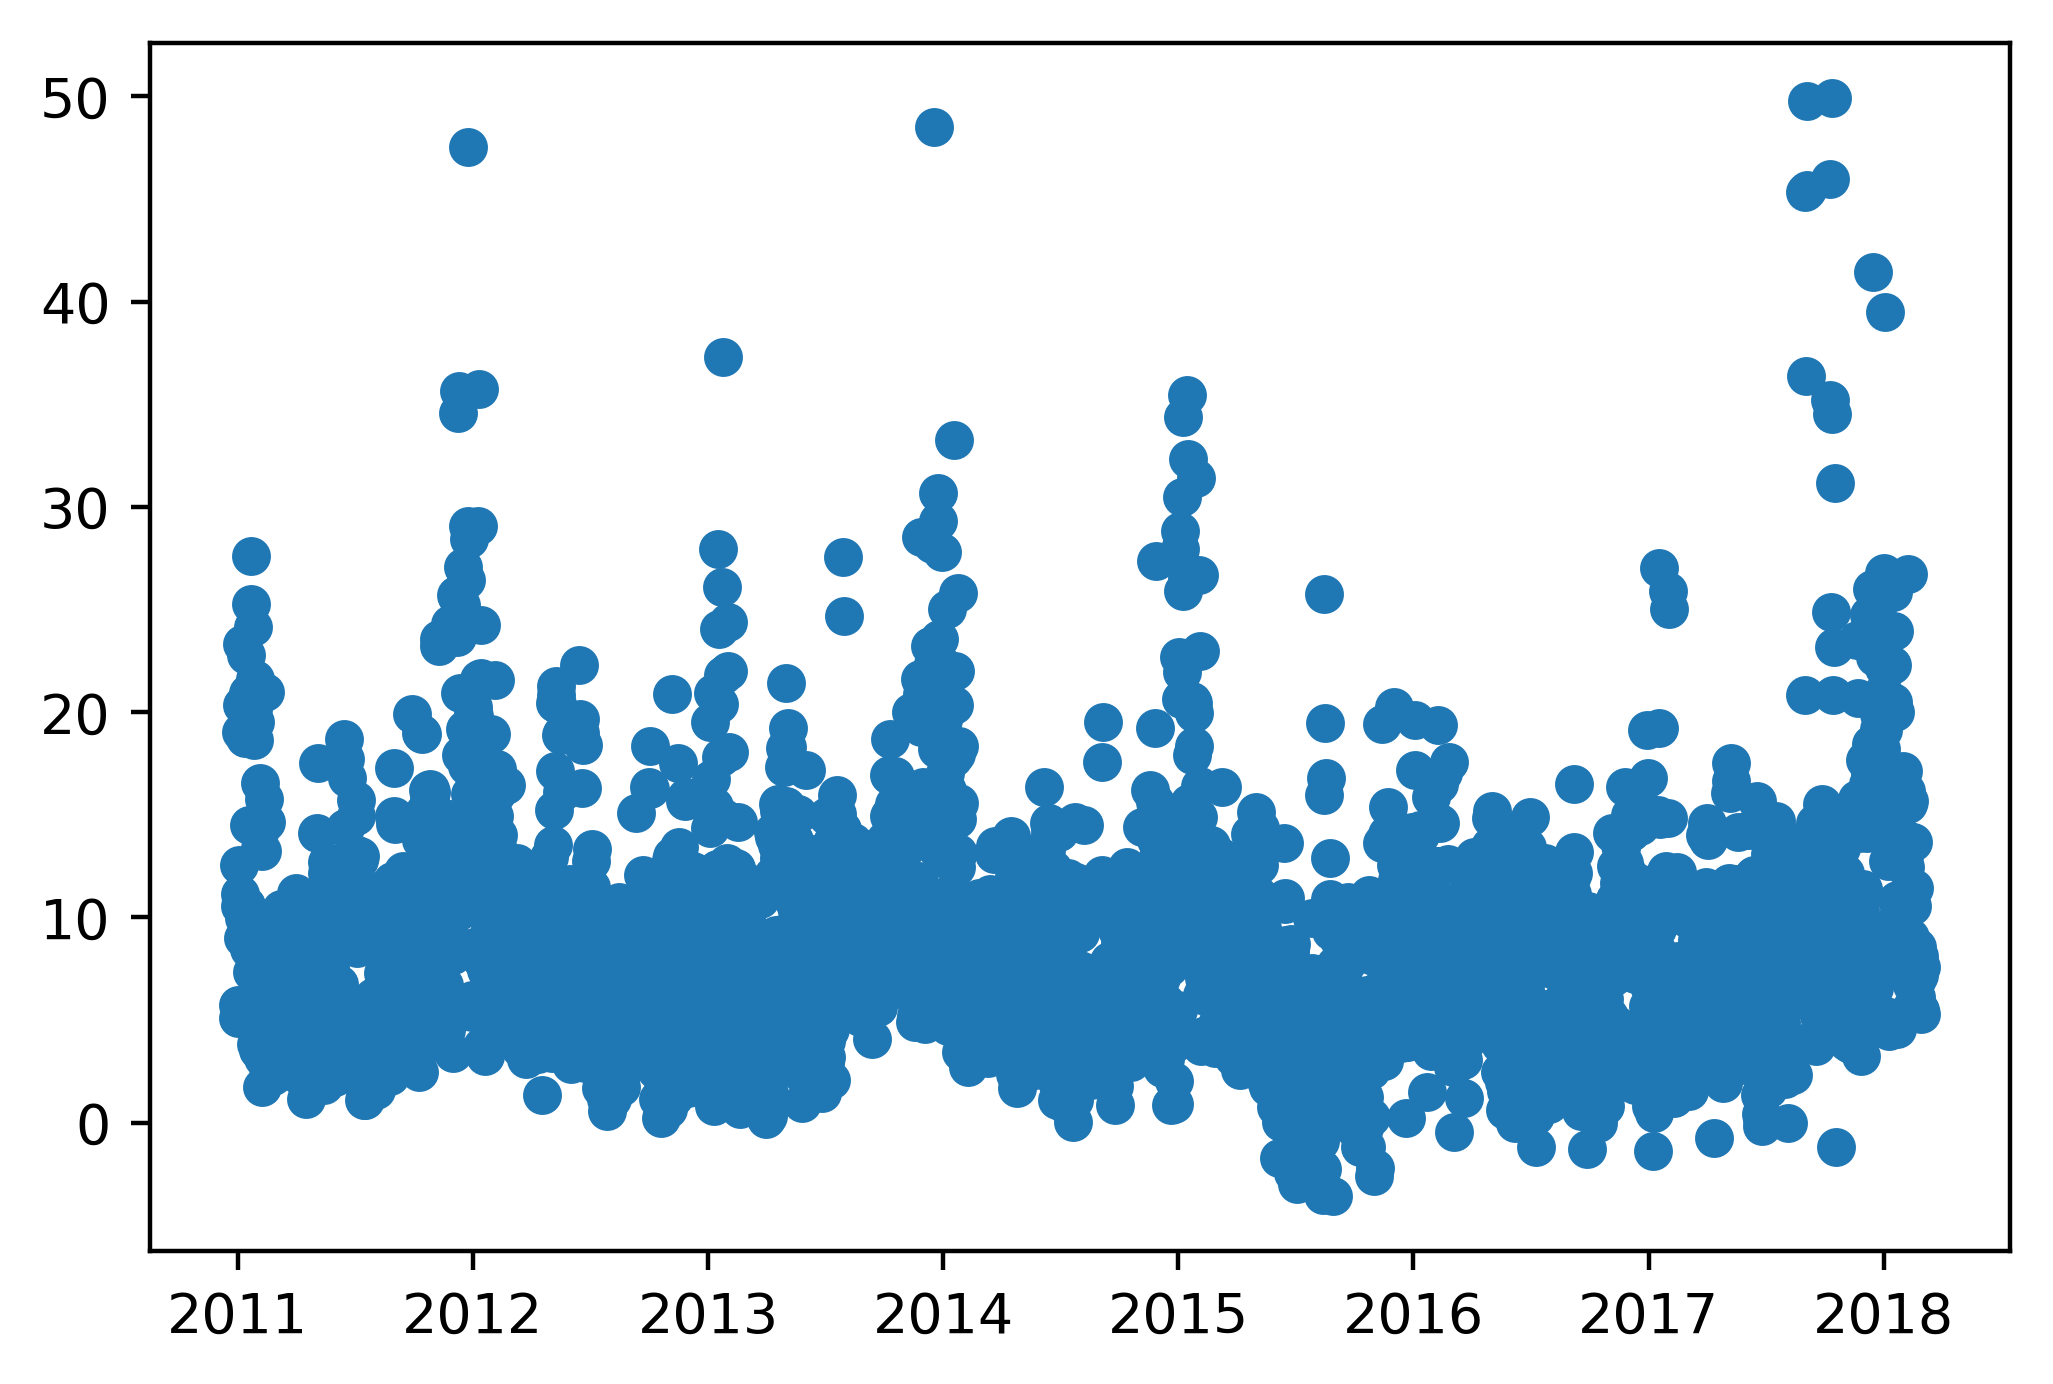

In [216]:
plt.scatter(aq.index,aq['Part Mean'])

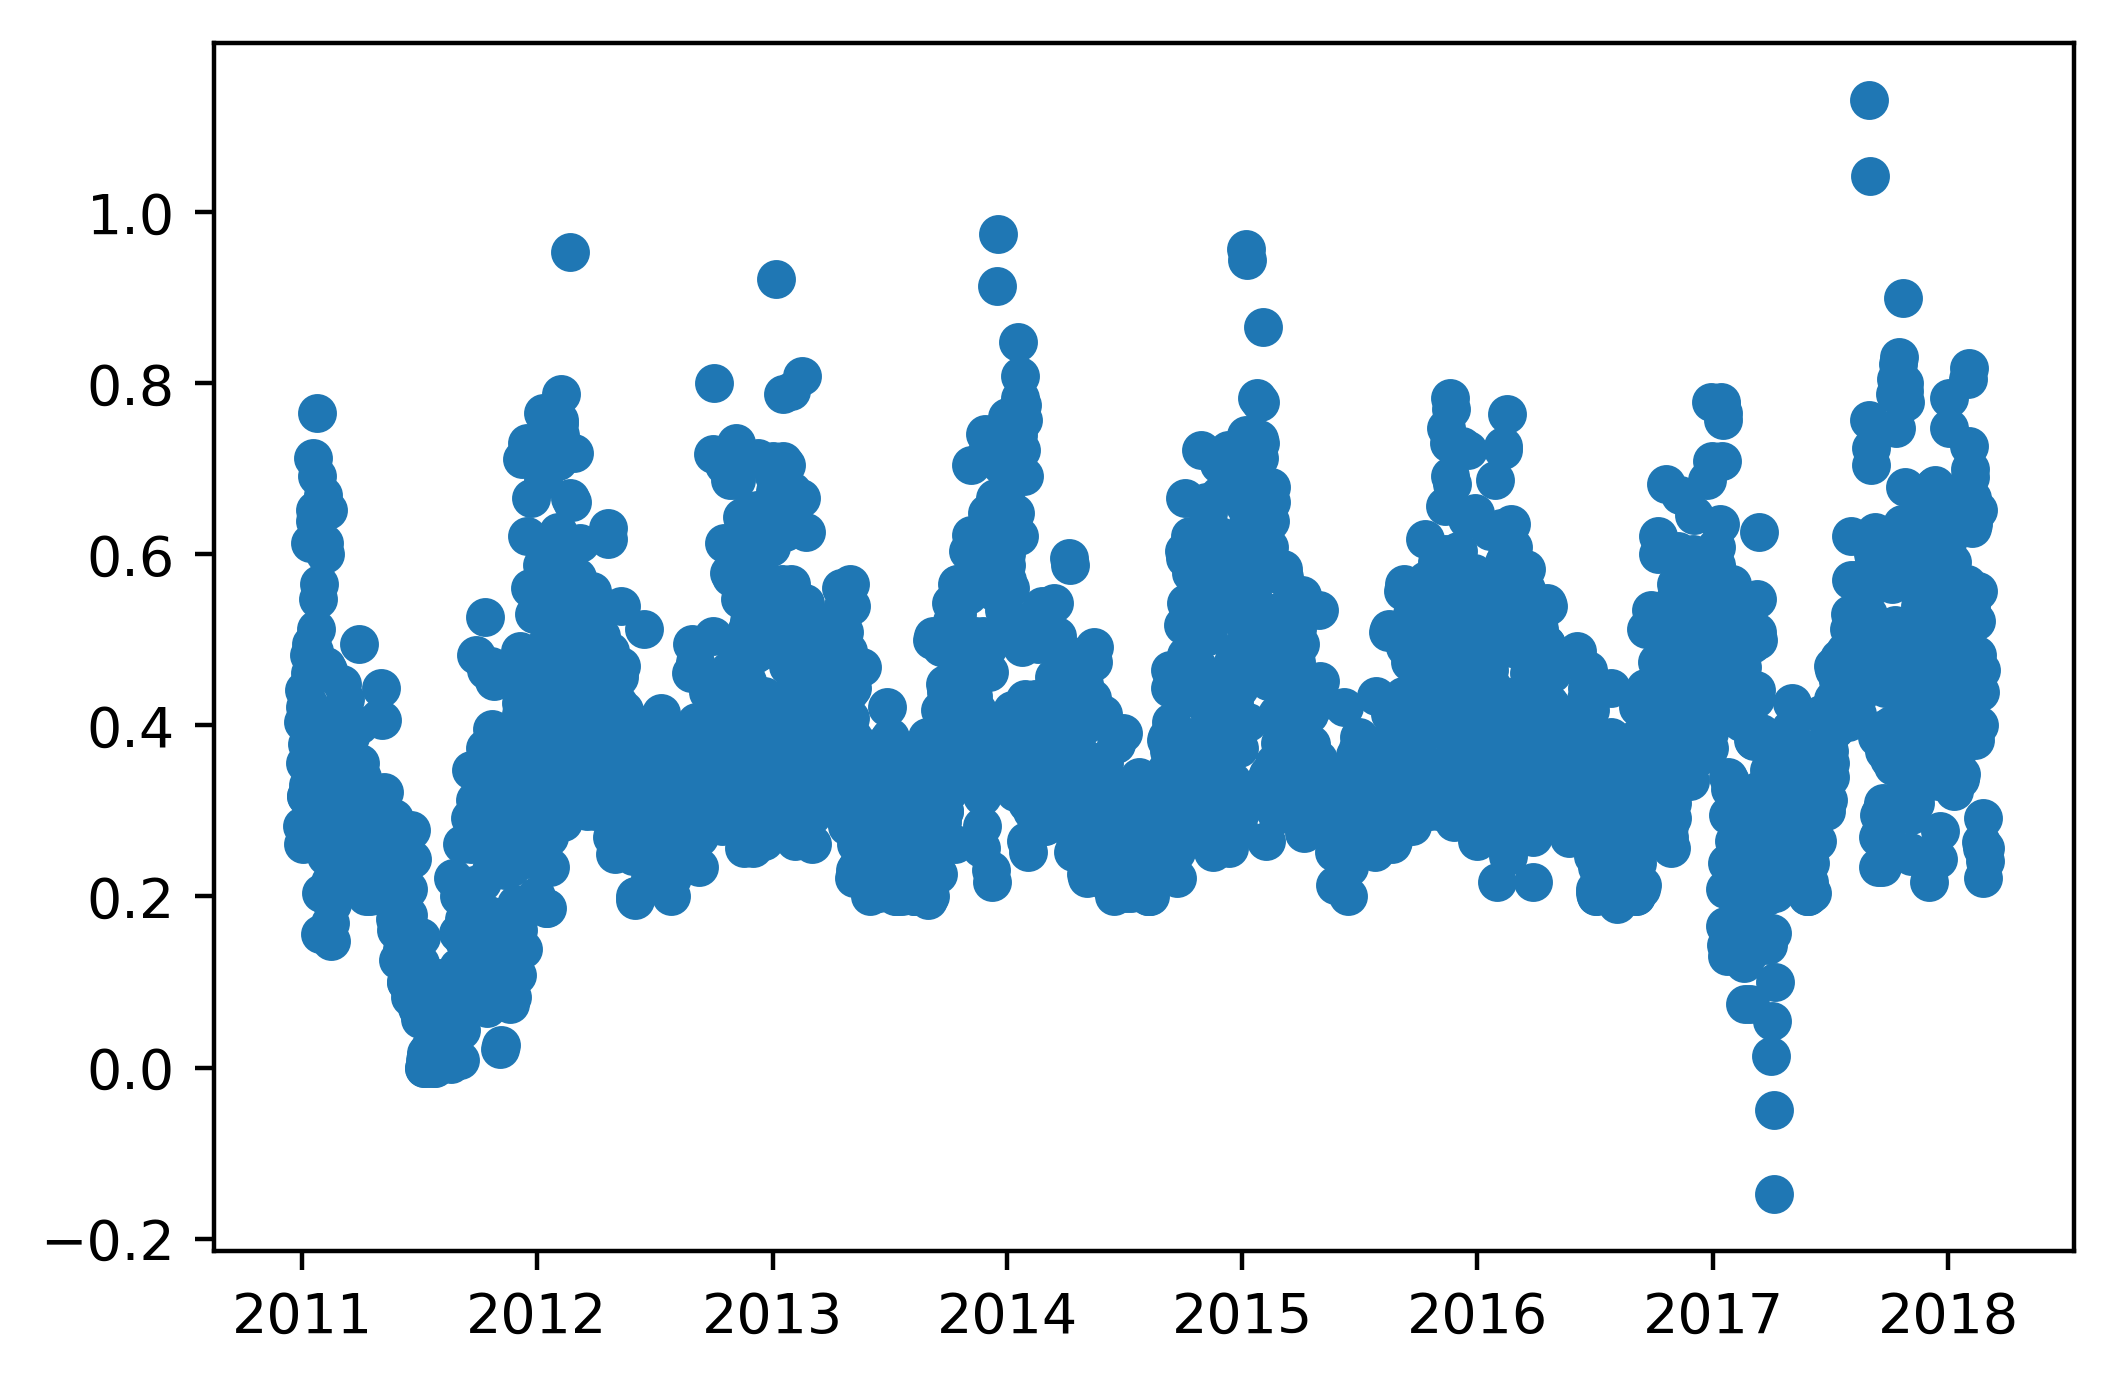

In [217]:
plt.scatter(aq.index,aq['CO Mean'])

In [799]:
          [(i,np.avg(aq[aq['Date Local']== x])) for x in aq['Date Local'].unique()]

Latitude   Longitude  Date Local   CO Mean  CO Max Value  CO Max Hour  \
72  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
73  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
74  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
75  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
76  37.814781 -122.282347  2015-01-10  0.579167           1.0            5   

     Oz Mean  Oz Max Value  Oz Max Hour   SO Mean  SO Max Value  SO Max Hour  \
72  0.008118         0.016            9  0.913636           2.4           15   
73  0.008118         0.016            9  0.913636           2.4           15   
74  0.008118         0.016            9  0.866667           1.4           14   
75  0.008118         0.016            9  0.866667           1.4           14   
76  0.008118         0.016            9  0.913636           2.4           15   

    Part Mean  Part Max Value  Part Max Hour  AQI  Category  \
72  17.458333            25.0              2   72  Moderate   
73  17.400000            17.4              0   72  Moderate   
74  17.458333            25.0              2   72  Moderate   
75  17.400000            17.4              0   72  Moderate   
76  17.458333            25.0              2   72  Moderate   

   AQ Defining Parameter  
72                 PM2.5  
73                 PM2.5  
74                 PM2.5  
75                 PM2.5  
76                 PM2.5

In [798]:
aq['CO Mean'].diff()

72            NaN
73       0.000000
74       0.000000
75       0.000000
76       0.013950
77       0.000000
78       0.000000
79       0.000000
80      -0.013950
81       0.000000
82       0.000000
83       0.000000
84       0.038950
85       0.000000
86       0.000000
87       0.000000
104      0.174094
105      0.000000
106      0.000000
107      0.000000
108      0.050906
109      0.000000
110      0.000000
111      0.000000
136     -0.376993
137      0.000000
138      0.000000
139      0.000000
140      0.026993
141      0.000000
           ...   
17326    0.000000
17327    0.000000
17328   -0.005797
17329    0.000000
17330    0.000000
17331    0.000000
17348    0.079710
17349    0.000000
17350    0.000000
17351    0.000000
17352   -0.013043
17353    0.000000
17354    0.000000
17355    0.000000
17356    0.026087
17357    0.000000
17358    0.000000
17359    0.000000
17360   -0.005254
17361    0.000000
17362    0.000000
17363    0.000000
17364    0.044384
17365    0.000000
17366    0

In [ ]:
#creating a function to find out if the data is stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', 'Lags Used', 'Observations USed'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
    rolmean = pd.rolling_mean(timeseries, window = 12)
    rolstd = rolling_std(timeseries, window=12)
    
    #Plotting the rolling statistics
    orig = plt.plot(timeseries, color='black' label='Original')
    mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False);
    

In [ ]:
#helper function to visualize 
import statsmodels.tsa.api as smt

def plots(data, lags= None):
    layout =abs (1,3)
    raw = plt.subplot2grid(layout, (0,0))
    acf = plt.subplot2grid(layout, (0,1))
    pacf = plt.subplot2grid(layout, (0,2))
    
    data.plot(ax=raw)
    smt.graphics.plot(data, lags=lags, ax =acf)
    smt.graphics.plot(data, lags=lags, ax =pacf)
    sns.despine()
    plt.tight_layout();

In [ ]:
plots(aq['CO Mean', lags =75)

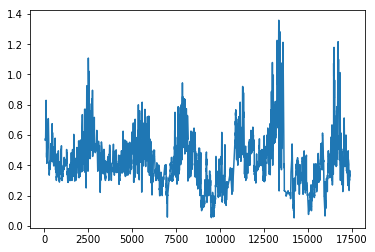

In [797]:

plt.plot(aq['CO Mean']);

# Distribution Prediction

Training a model to predict the distribution of other AQ factors in the air.  I will then cluster it all together in the next section, to find large (or larger) concentrations of the factors.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = aq[['Latitue', 'Longitude', 'CO Mean', 'SO Mean', 'Part Mean', 'Oz Mean']]
y = df[df['latlong'].isin(list(aq['latlong']))]['co2ppm']

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target)

# Clustering

Now that I am done with the EDA and data cleaning, I am goign to cluster the air quality data.

In [759]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score


In [761]:
clusterdf = aq[['CO Mean', 'SO Mean', 'Part Mean', 'Oz Mean']]

In [766]:
km.inertia_

2751.600271664947

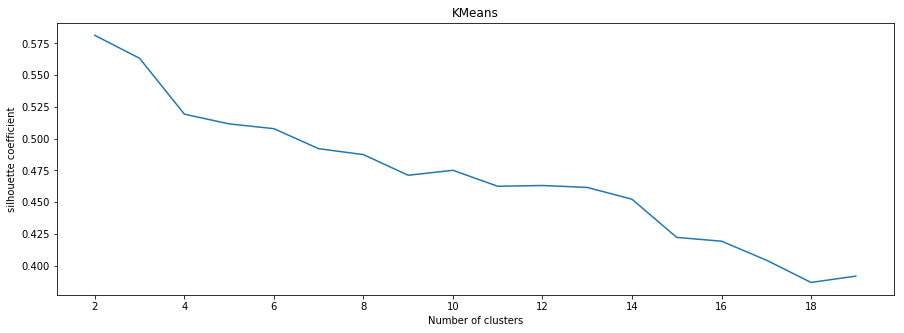

In [795]:
Sil_coefs = []
inertia = []
for k in range(2,20):
    km = KMeans(n_clusters = k)
    km.fit(clusterdf)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(clusterdf, labels, metric='euclidean'))
    inertia.append(km.inertia_)
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
#inertia says 4 clusters, silhouette is about .51
ax1.set_title('KMeans')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2));

In [783]:
km = KMeans(n_clusters = 4)
km.fit(clusterdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [784]:
mu_digits = km.cluster_centers_
kmlabels = km.labels_

In [787]:
print(len(kmlabels))
print(len(clusterdf))

11742
11742


# Time Series Exploration

Starting on time series items.  Checking for stationarity, ploting concentrations vs time.

In [83]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
"""plotly.tools.set_credentials_file(username='djmorcode', api_key='g4D9PR85TaaUkKlH8CWZ')
data = [go.Scatter(x=annual_temp.index, y=annual_temp.temp)]
py.iplot(data)"""

"plotly.tools.set_credentials_file(username='djmorcode', api_key='g4D9PR85TaaUkKlH8CWZ')\ndata = [go.Scatter(x=annual_temp.index, y=annual_temp.temp)]\npy.iplot(data)"

In [41]:
"""#pulling in climate data
with open('climate_data.pkl', 'rb') as picklefile:
    aq = pickle.load(picklefile)
"""

"#pulling in climate data\nwith open('climate_data.pkl', 'rb') as picklefile:\n    aq = pickle.load(picklefile)\n"

In [84]:
aq2.head()

State Name county Name  State Code  County Code       Date  AQI Category  \
0    Alabama     Baldwin           1            3 2008-01-04   38     Good   
1    Alabama     Baldwin           1            3 2008-01-07   15     Good   
2    Alabama     Baldwin           1            3 2008-01-10   15     Good   
3    Alabama     Baldwin           1            3 2008-01-13   38     Good   
4    Alabama     Baldwin           1            3 2008-01-16   31     Good   

  Defining Parameter Defining Site  Number of Sites Reporting  
0              PM2.5   01-003-0010                          1  
1              PM2.5   01-003-0010                          1  
2              PM2.5   01-003-0010                          1  
3              PM2.5   01-003-0010                          1  
4              PM2.5   01-003-0010                          1

In [94]:
aq2.reset_index(level=0, inplace=True, drop=True)
aq2.drop_duplicates('Date Local',inplace=True)
aq2['Date Local'] = pd.to_datetime(aq2['Date Local'])
aq = aq2[['AQI', 'Date Local']].copy()

In [95]:
#aq2.set_index('Date Local', inplace=True)
aq2.head()

County Name Date Local  AQI  Category AQ Defining Parameter
0  San Francisco 2008-01-01   66  Moderate                 PM2.5
1  San Francisco 2008-01-02   69  Moderate                 PM2.5
2  San Francisco 2008-01-03   36      Good                 PM2.5
3  San Francisco 2008-01-04   33      Good                 Ozone
4  San Francisco 2008-01-05   32      Good                 PM2.5

In [96]:
sfc.set_index('Date', inplace=True)
aq2 = aq2.set_index(pd.DatetimeIndex(aq2['Date Local']))

In [97]:
len(sfc)/len(sfc['CO2 ppm'].resample('D').mean())

0.7441516138584543

In [262]:
cc = sfc['CO2 ppm'].resample('D').mean()
aqi

In [264]:
cc.isnull().values.any()

True

In [390]:
cc = sfc['CO2 ppm'].resample('W').mean()
aqi = aq2['AQI'].resample('W').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [244]:
sfc.head()

CO2 ppm           latlong
Date                                    
2008-01-02  397.260010  (37.76, -122.45)
2008-01-03  390.620000  (37.76, -122.45)
2008-01-04  390.169997  (37.76, -122.45)
2008-01-05  388.109998  (37.76, -122.45)
2008-01-06  388.410001  (37.76, -122.45)

In [104]:
def missVal(colname,df1):
    dates = df1.resample('D').asfreq().index
    coppm = list(np.arange(len(dates)))


    df = pd.DataFrame({'dates':list(dates),
                   colname:coppm}, columns=['dates',colname])

    for i in range(len(df)):
        if df.dates.values[i] in df1.index.values:
            cd =df.dates[i]
            last_val = df1.loc[cd,colname]
            df.loc[i,colname] = last_val
        elif df.dates.values[i+1] in df1.index.values:
            nday = df.dates[i]+datetime.timedelta(days = 1)
            avalue = df1.loc[nday,colname]
            df.loc[i,colname] =(avalue+last_val)/2
        else:
            df.loc[i,colname] =last_val
    return df

In [105]:
aq.index = pd.to_datetime(aq.index)
sfc.index = pd.to_datetime(sfc.index)

In [106]:
#no longer have missing values
cdf = missVal('CO2 ppm', sfc)
aqidf = missVal('AQI', aq)
cdf.set_index('dates',inplace=True)
aqidf.set_index('dates',inplace=True)

In [107]:
cdf

CO2 ppm
dates                 
2008-01-02  397.260010
2008-01-03  390.620000
2008-01-04  390.169997
2008-01-05  388.109998
2008-01-06  388.410001
2008-01-07  388.059998
2008-01-08  387.940003
2008-01-09  388.470013
2008-01-10  397.310010
2008-01-11  386.189990
2008-01-12  400.010002
2008-01-13  399.699988
2008-01-14  391.189998
2008-01-15  404.999999
2008-01-16  388.599990
2008-01-17  393.489987
2008-01-18  395.949988
2008-01-19  396.079995
2008-01-20  392.020011
2008-01-21  388.420012
2008-01-22  401.310012
2008-01-23  393.880007
2008-01-24  395.829993
2008-01-25  392.129994
2008-01-26  389.680004
2008-01-27  393.610011
2008-01-28  390.880014
2008-01-29  390.880014
2008-01-30  390.880014
2008-01-31  390.880014
...                ...
2017-03-02  409.459986
2017-03-03  407.299987
2017-03-04  411.290006
2017-03-05  410.629989
2017-03-06  410.629989
2017-03-07  408.874999
2017-03-08  407.120009
2017-03-09  409.859989
2017-03-10  407.429994
2017-03-11  403.479993
2017-03-12  408.430002
2017-03-13  407.949992
2017-03-14  408.794993
2017-03-15  409.639993
2017-03-16  409.839995
2017-03-17  409.080007
2017-03-18  410.829991
2017-03-19  409.050001
2017-03-20  412.530004
2017-03-21  410.550012
2017-03-22  410.779990
2017-03-23  410.979992
2017-03-24  411.320012
2017-03-25  410.929992
2017-03-26  411.170011
2017-03-27  410.805005
2017-03-28  410.440000
2017-03-29  410.559995
2017-03-30  410.559995
2017-03-31  411.249988

[3377 rows x 1 columns]

In [112]:
cdf.isnull().values.any()

False

In [110]:
nulls = aqidf[aqidf.isnull().values].copy()

In [293]:
#For nulls, if any are in dataset
for i in nulls.index:
    prevdate = i-datetime.timedelta(days = 2)
    postdate = i+datetime.timedelta(days = 5)
    fill = (aq.loc[prevdate,'AQI']+aq.loc[postdate,'AQI'])/2
    aqidf.loc[i,'AQI'] = fill

In [294]:
# plot binned yearly segments using resample method, capital A for annual
#monthly_temp.resample('A').temp.plot();

In [295]:
# violinplot months to determine variance and range
#sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp);

## Time Series with Prophet

Facebooks Prophet package is better atm with my data because it is incomplete and it allows for specifying change points in the trend to give an idea of how an event will affect forecasting into the future.

In [243]:
from fbprophet import Prophet
from  fbprophet.plot  import add_changepoints_to_plot
from sklearn.model_selection import train_test_split

In [131]:
cdf.drop('index',axis=1,inplace=True)

In [128]:
cdf.reset_index(inplace=True, drop=True)
aq2.reset_index(inplace=True, drop=True)

In [137]:
paq = aq2[['Date Local','AQI']]
paq.columns = ['ds','y']
cdf.columns = ['ds','y']

In [416]:
mlCO2.columns=['ds','y1']
mlCO2.head()

ds      y1
0  2008-01-05  384.36
1  2008-01-12  384.41
2  2008-01-19  385.47
3  2008-01-26  386.06
4  2008-02-02  386.19

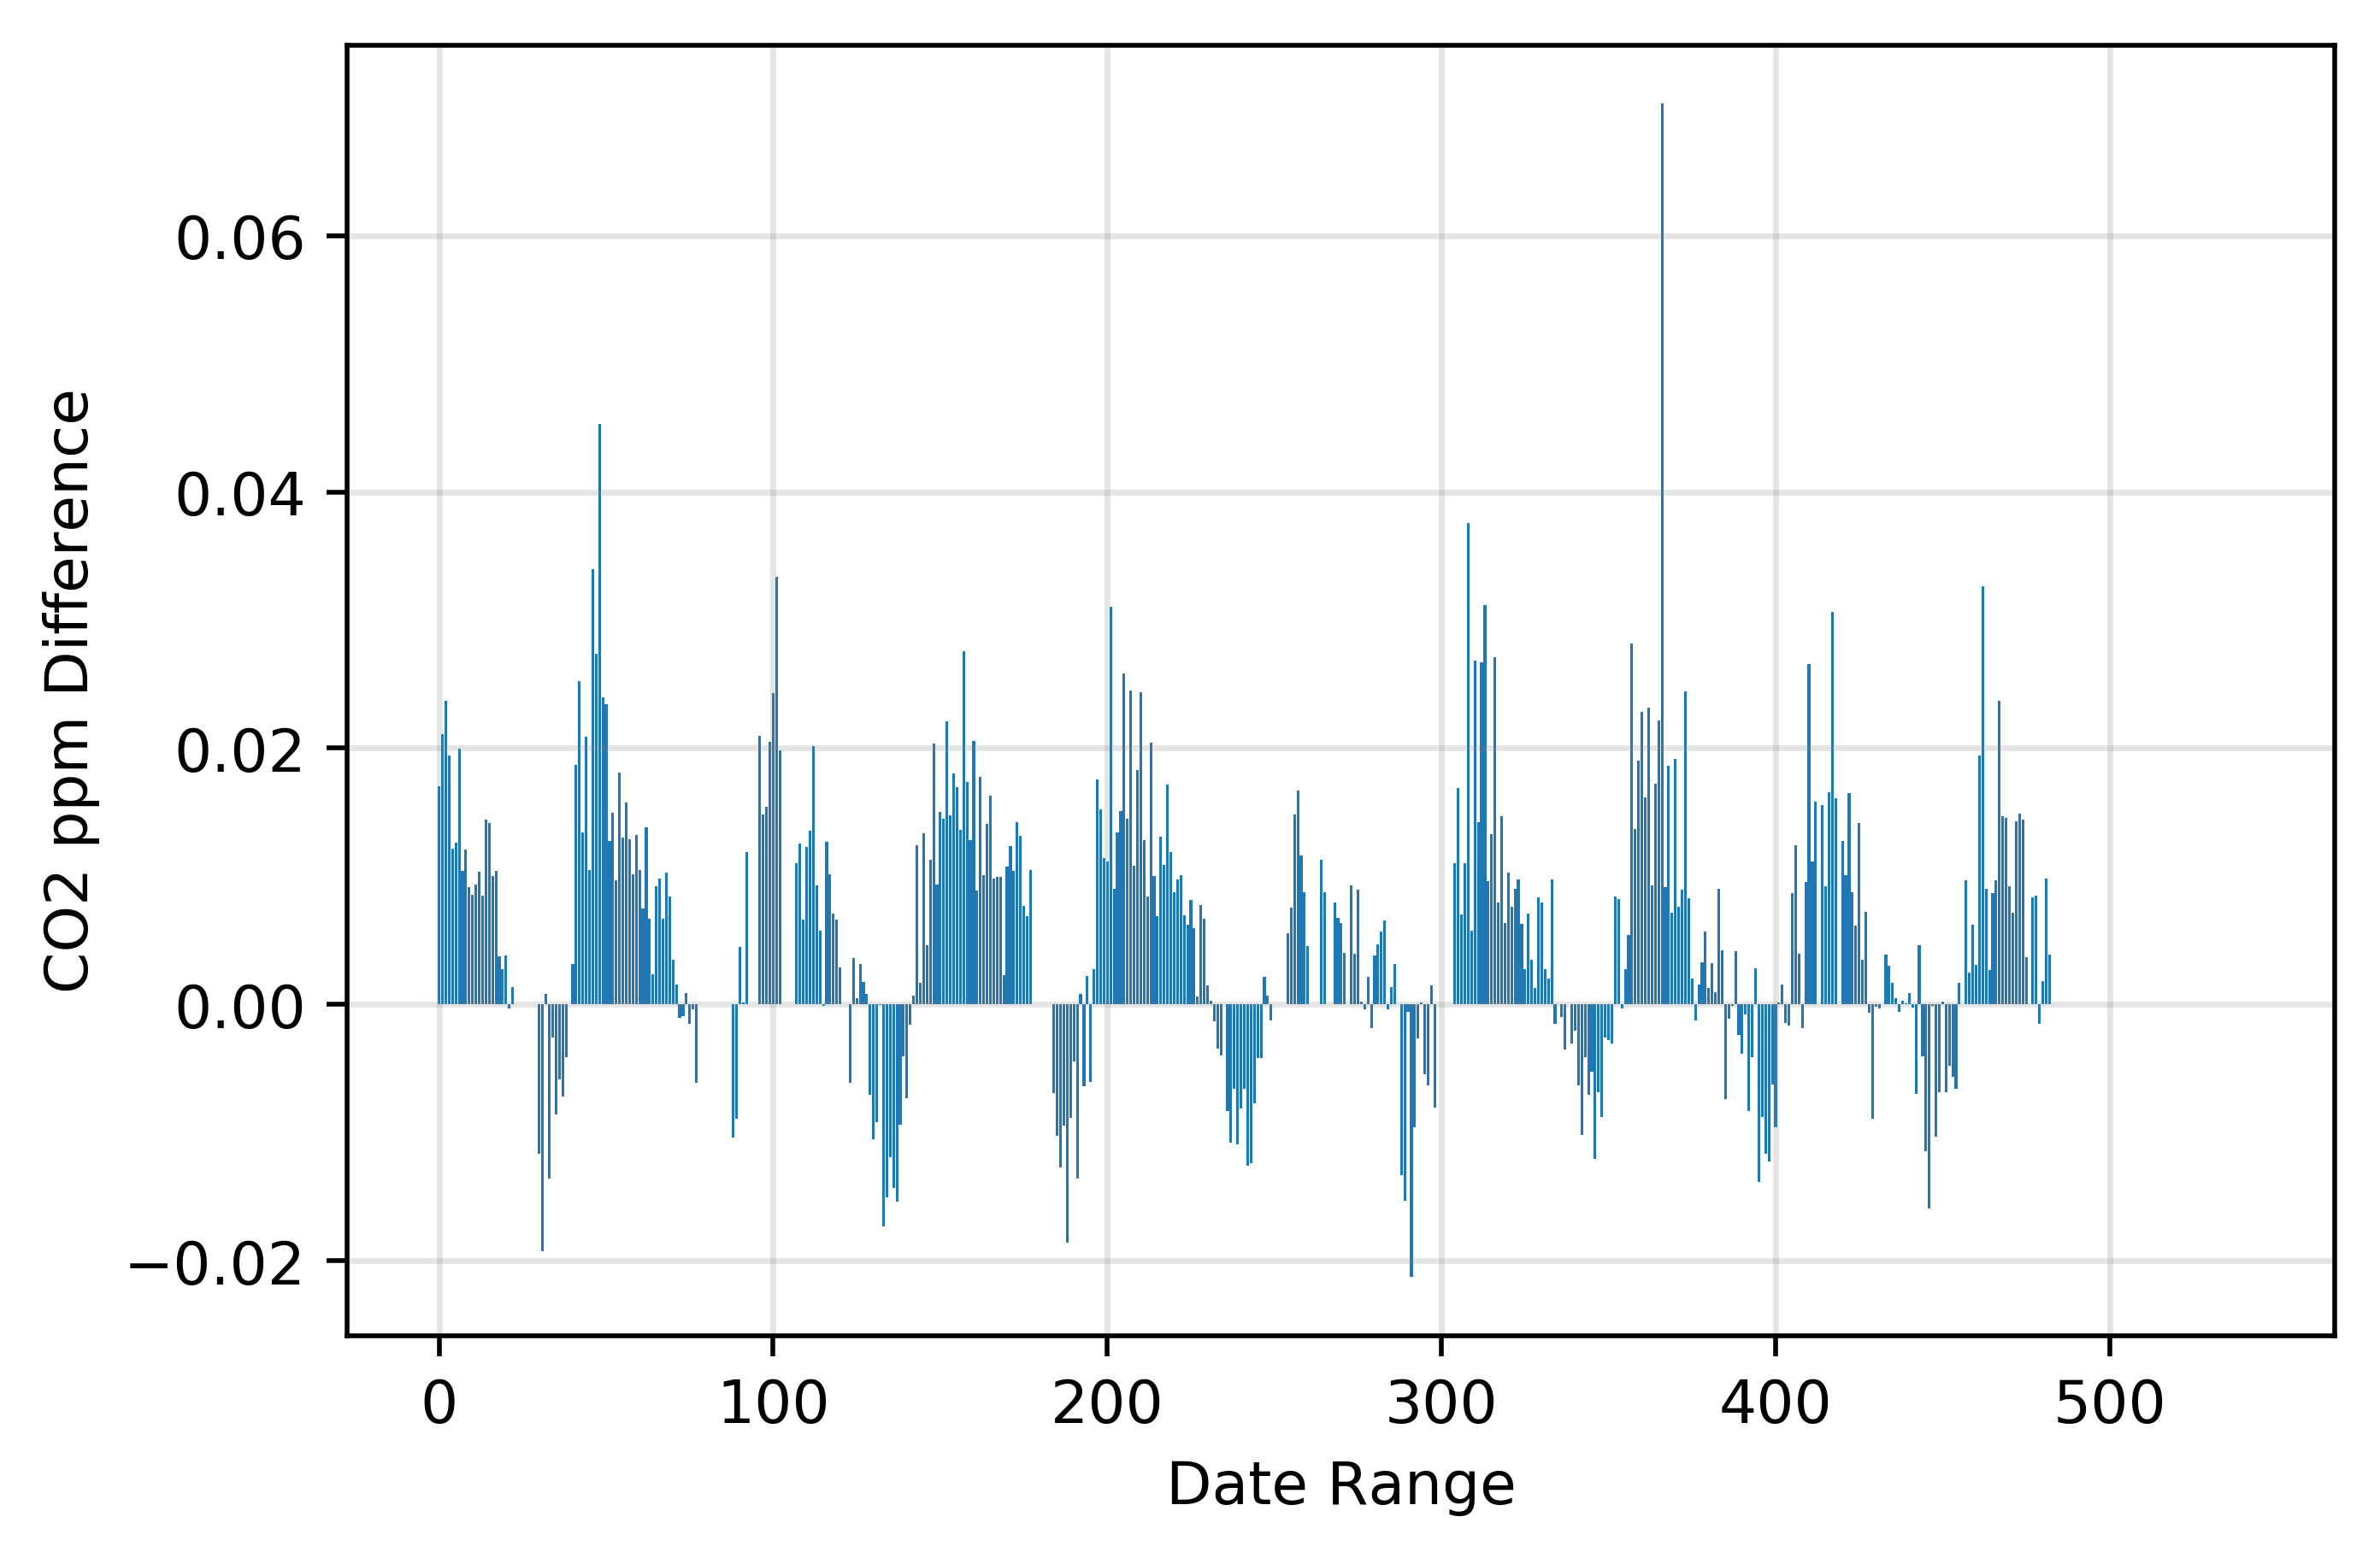

In [453]:
sfmldf = ((tocom['y']-mlCO2['y1'])/mlCO2['y1']).fillna(0)
plt.bar(range(len(sfmldf)),sfmldf)
plt.grid(True,which='Major',c='gray',ls='-',lw=1, alpha=.2)
plt.ylabel('CO2 ppm Difference')
plt.xlabel('Date Range')
plt.show()

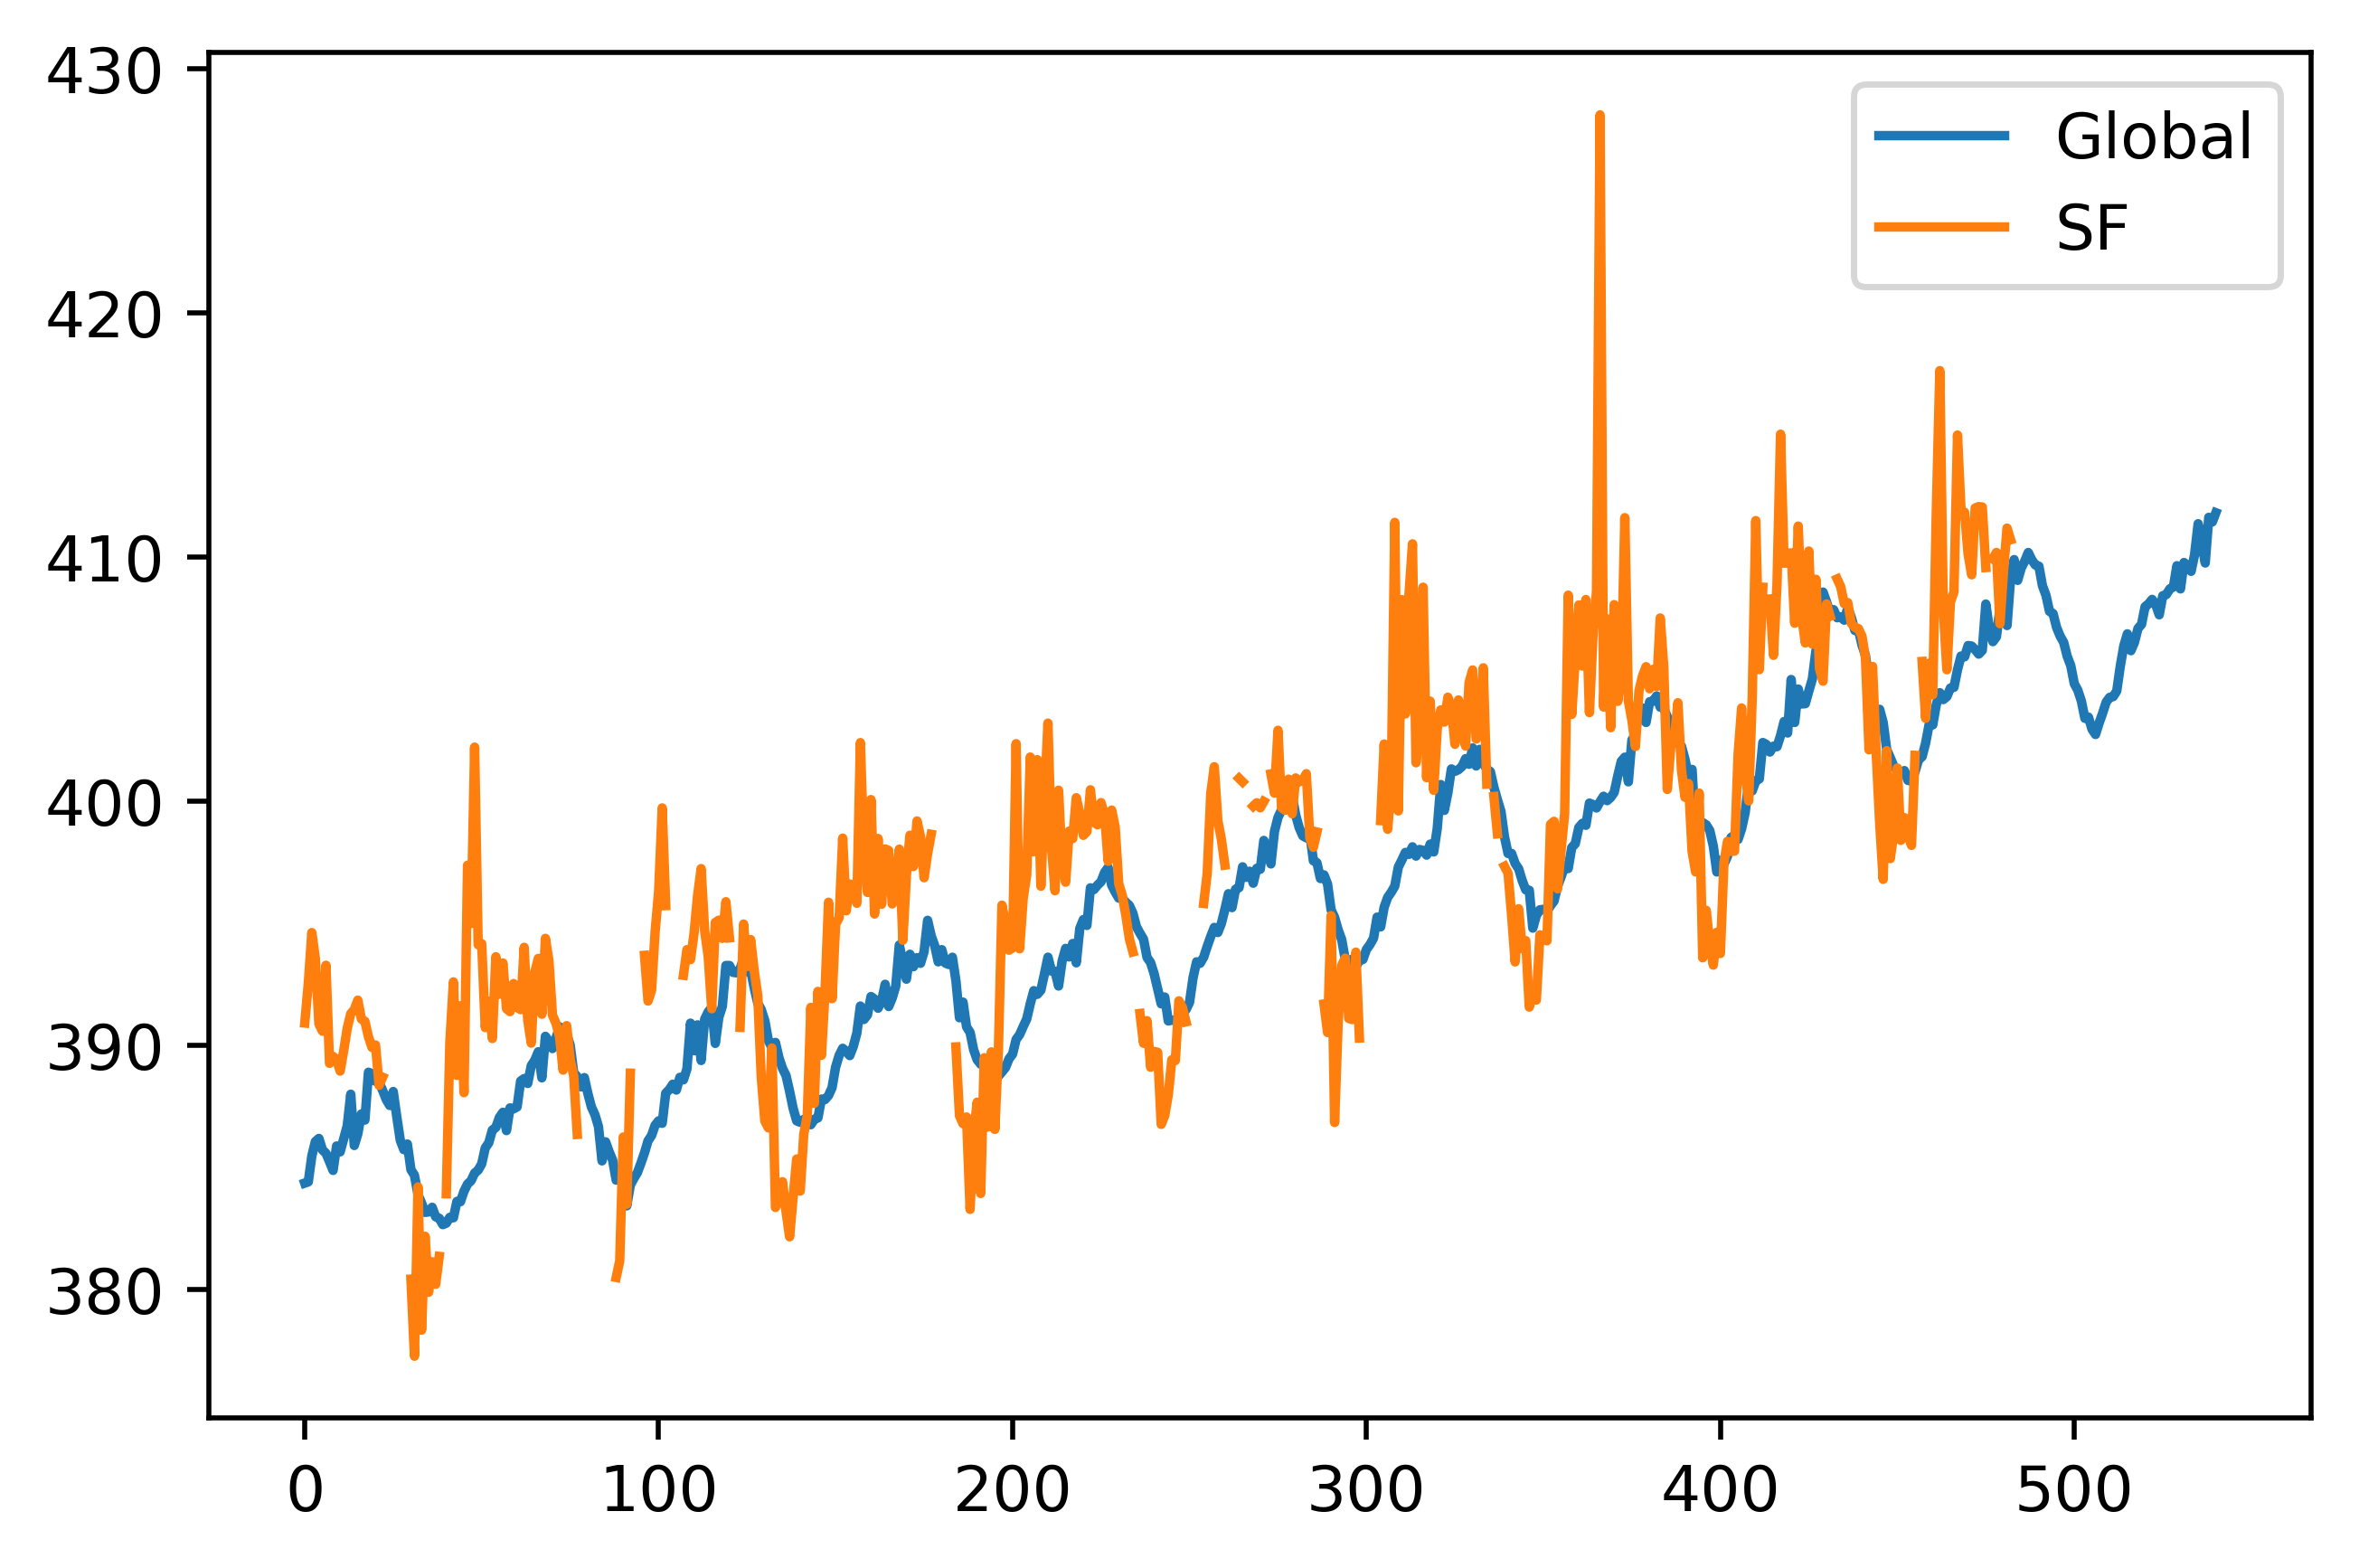

In [420]:
mlCO2['y1'].plot(legend=True)
tocom['y'].plot(legend = True)
plt.legend(['Global','SF'])
plt.show()

In [138]:
cdf.head()

ds           y
0 2008-01-02  397.260010
1 2008-01-03  390.620000
2 2008-01-04  390.169997
3 2008-01-05  388.109998
4 2008-01-06  388.410001

In [140]:
paq.head()

ds   y
0 2008-01-01  66
1 2008-01-02  69
2 2008-01-03  36
3 2008-01-04  33
4 2008-01-05  32

In [ ]:
#looking at Particle concentration in air
parts = pdf[['Date Local','Part Mean']]
parts.columns= ['ds','y']

In [ ]:
#adding events into prophet 
verticalforest = pd.DataFrame({
  'event': 'vertical forest',
  'ds': pd.to_datetime(['2020-1-1']),
  'lower_window': -14,
  'upper_window': 14,
})
citytree = pd.DataFrame({
  'event': 'city tree',
  'ds': pd.to_datetime(['2020-1-1']),
  'lower_window': -14,
  'upper_window': 14,
})
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

### Carbon Dioxide

In [650]:
ctrain, ctest = train_test_split(cdf, test_size = .3, shuffle = False)

ptrain,ptest = train_test_split(parts, test_size = .3, shuffle = False)

In [651]:
help(m.plot_weekly)

Help on method plot_weekly in module fbprophet.forecaster:

plot_weekly(ax=None, uncertainty=True, weekly_start=0) method of fbprophet.forecaster.Prophet instance



In [652]:
m = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            changepoint_prior_scale=.1,
            daily_seasonality=False)
m.fit(ctrain)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [654]:
future = m.make_future_dataframe(periods=1025)

In [655]:
forecast = m.predict(future)

In [657]:
_, yhat = train_test_split(forecast, test_size = .3, shuffle = False)

In [658]:
dif = len(ctest)-len(yhat)
yhat.drop(yhat.index[:-dif], inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [660]:
yhat=yhat['yhat']

In [1408]:
def add_changepoints_to_plot(m):
    for cp in m.changepoints:
        plt.axvline(cp,c='gray', ls='--',lw=1)
    return

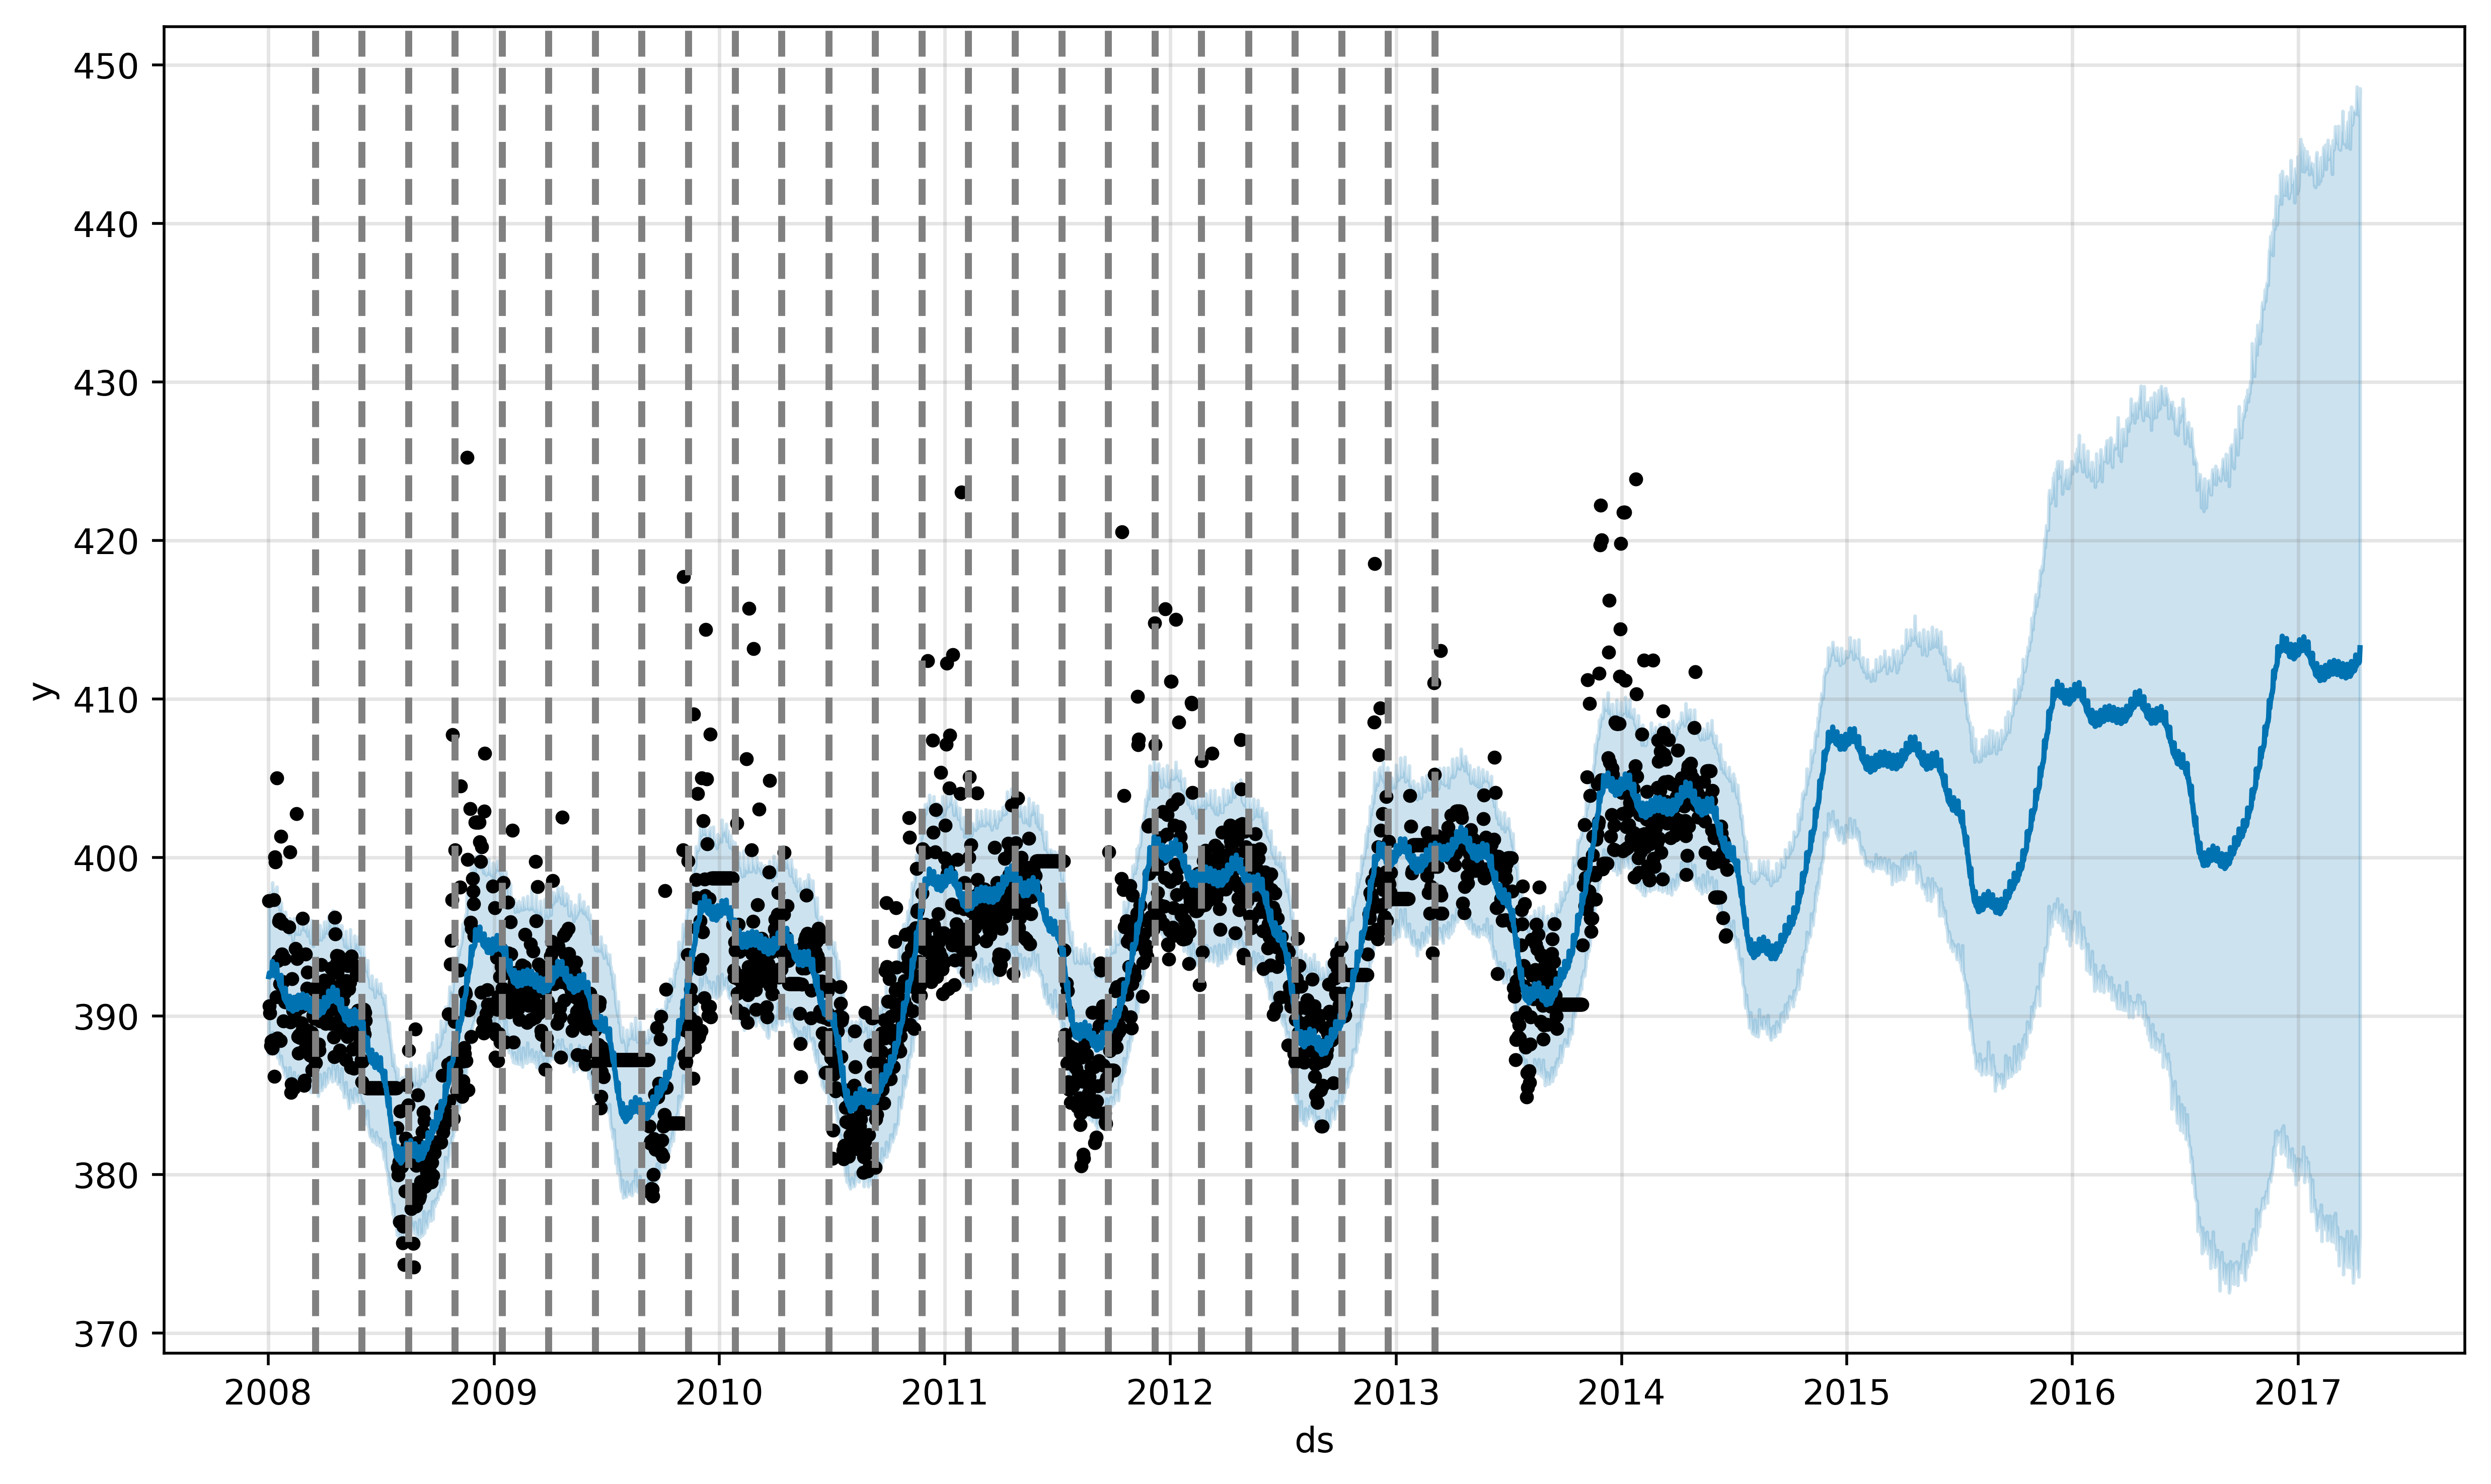

In [315]:
fig = m.plot(forecast)
add_changepoints_to_plot(m)


In [328]:
m.

{'beta': array([[ 1.00857207e-02,  8.27042913e-03, -5.26159445e-03,
          3.50002439e-03, -7.92717420e-04,  3.17465928e-04,
         -9.67476393e-04,  2.01769971e-04,  1.30845793e-04,
         -7.21428773e-04, -9.50536059e-06,  1.02904930e-04,
          2.43011924e-04, -3.14366934e-04,  8.04964005e-04,
          2.26820074e-04, -7.97504783e-05, -5.73184110e-04,
          4.50753856e-04,  2.49011803e-04, -4.24152259e-04,
          1.10116224e-04,  2.55053226e-04, -4.63083175e-04,
          3.59997084e-04,  4.67519268e-04]]),
 'delta': array([[ 3.54131657e-03,  1.04777012e-01,  1.90246475e-02,
         -1.47900693e-01,  5.23605740e-03,  1.01866687e-01,
          5.59867708e-02, -1.21927009e-01,  1.99031561e-02,
         -5.71427628e-02,  6.79418990e-03,  1.35742733e-01,
         -4.06116247e-02,  7.80358806e-07,  2.08733398e-02,
         -8.12762200e-04, -1.40410644e-01,  3.53704486e-02,
          3.80496295e-02, -1.07480243e-04, -2.99655902e-02,
         -9.49145659e-03, -1.34197766

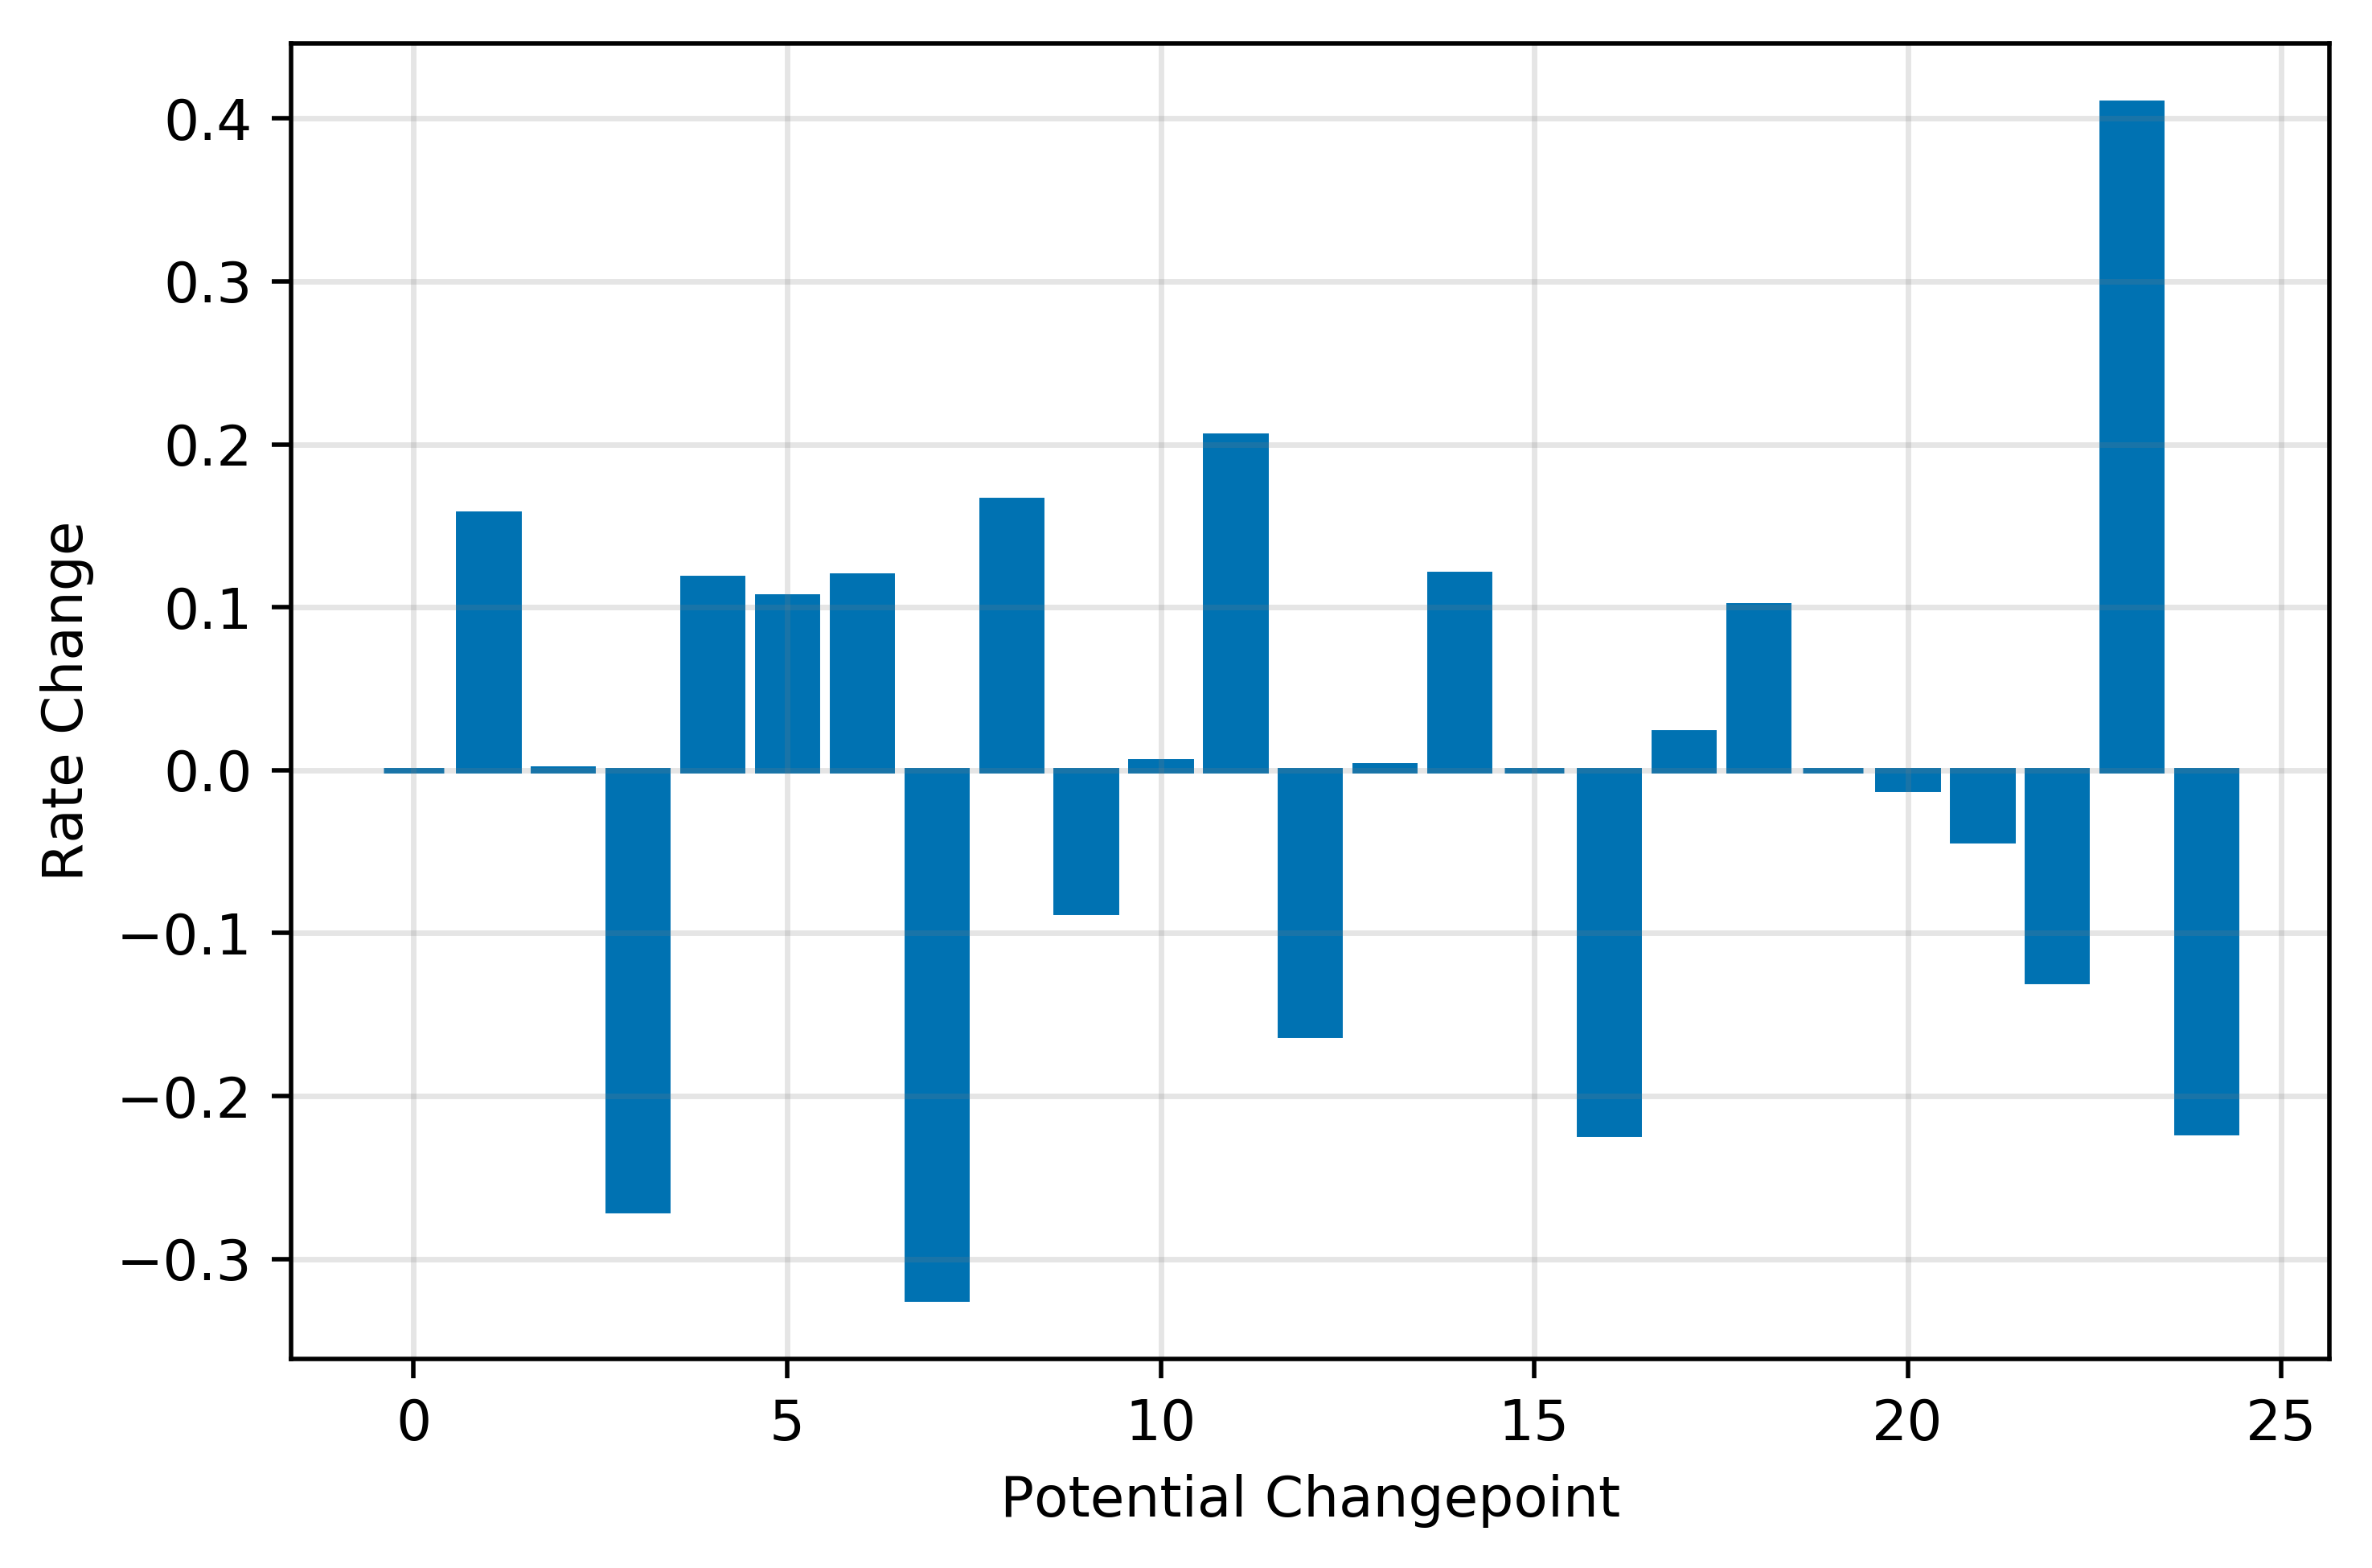

In [1440]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True,which='Major',c='gray',ls='-',lw=1, alpha=.2,)
ax.set_facecolor='#F2F2F2'
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
fig.tight_layout()

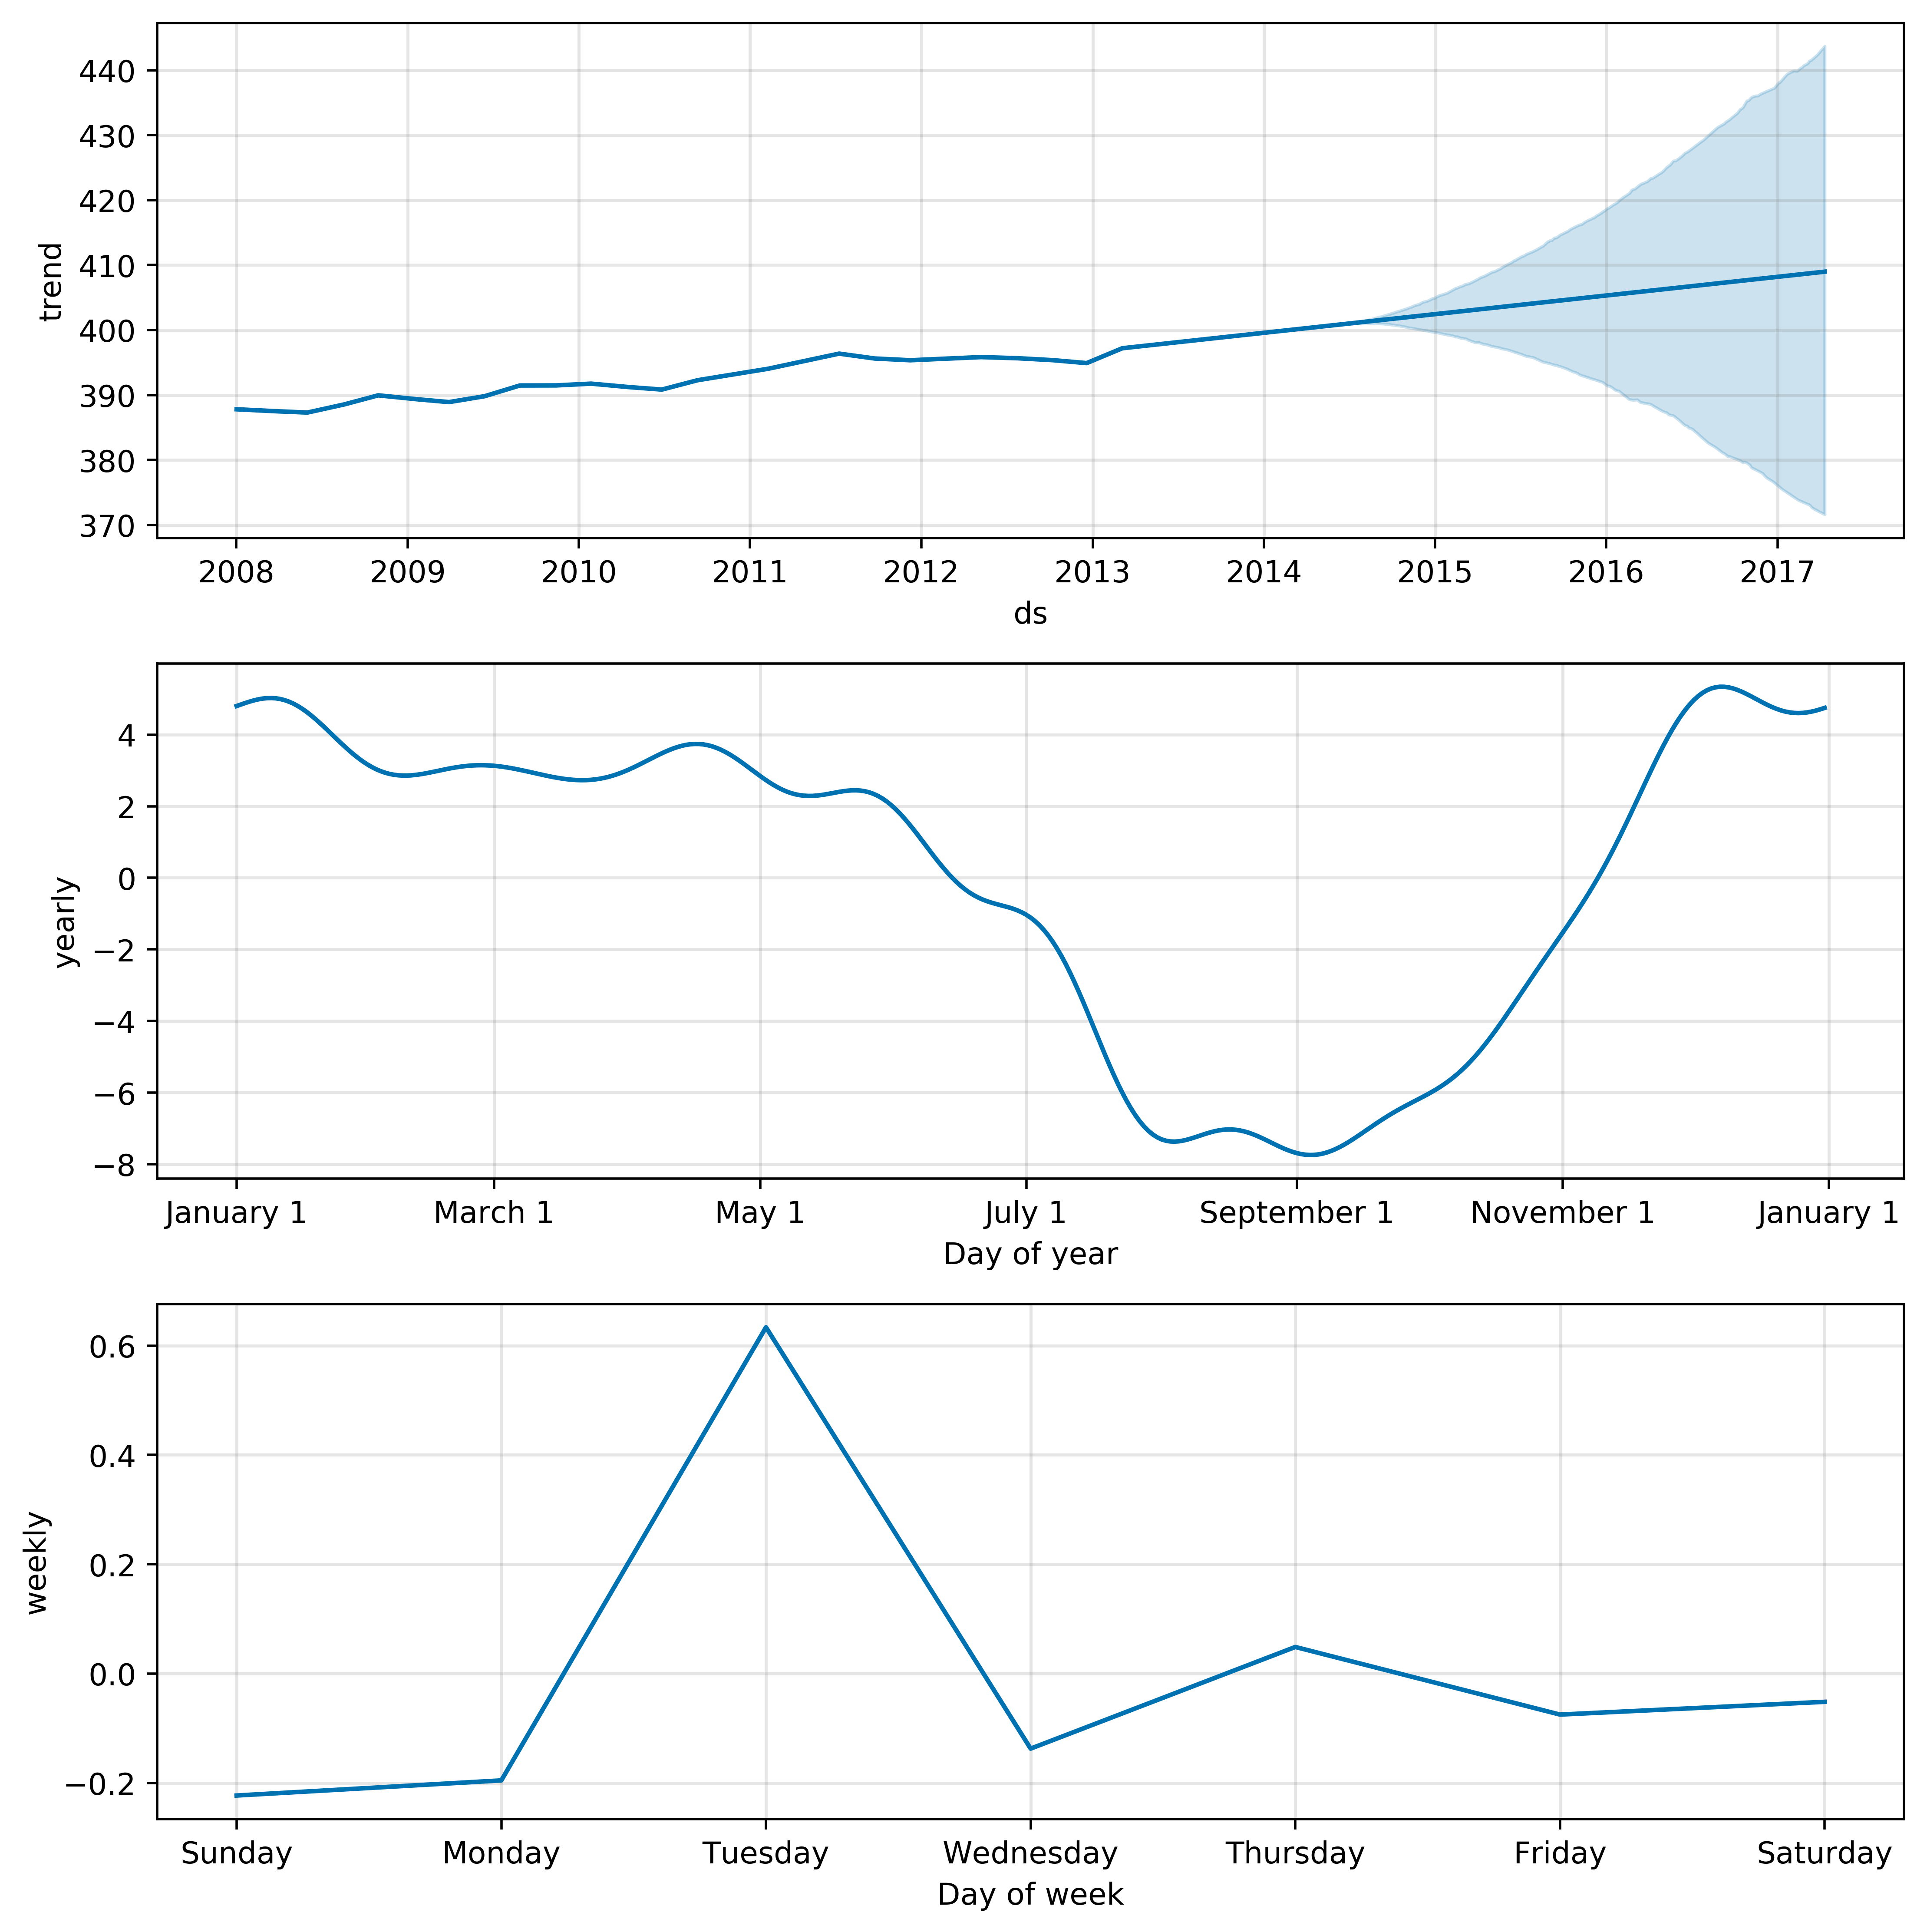

In [317]:
m.plot_components(forecast);

In [350]:
#predictions are 4.78 ppm off from the actual values
rms = math.sqrt(mean_squared_error(ctest['y'], yhat))
rms/np.mean(ctest['y'])

0.011722599995666803

### Los Angeles Particle Matter

In [692]:
laqi = laqi[:-1]
laqi['PM25'] = [int(x) for x in laqi['PM25']]

In [862]:
laqi.columns

Index(['Main Pollutant', 'Overall AQI Value', 'CO', 'SO2', 'NO2', 'Ozone',
       'PM10', 'PM25', 'ds'],
      dtype='object')

In [873]:
lapm = laqi[['ds','PM25']]
lapm.columns=['ds','y']


In [884]:
def conversion(value):
    AQIlist = [(1,50), (51,100),(101,150),(151,200),(201,300),(301,500)]
    for i in AQIlist:
        
    

0.8322259136212624
0.30392156862745096
0.308


In [1014]:
bei.dropna(inplace=True)
bei=bei[bei['y']>0]

In [1032]:
bei.set_index('ds',inplace=True)

KeyError: 'ds'

In [1033]:
newbei =bei.resample('D').mean()
newbei.reset_index(inplace=True)

In [1260]:
lapm

ds  Mean PM25  AQI
0     2010-01-02        2.2    9
1     2010-01-08        4.2   18
2     2010-01-11        3.2   13
3     2010-01-20        5.9   25
4     2010-01-23        3.2   13
5     2010-01-26       12.1   51
6     2010-01-29        8.8   37
7     2010-02-01       22.1   72
8     2010-02-07        2.8   12
9     2010-02-22        4.2   18
10    2010-02-25       10.5   44
11    2010-02-28        4.6   19
12    2010-03-06        9.3   39
13    2010-03-09        3.5   15
14    2010-03-12        7.2   30
15    2010-03-18        9.5   40
16    2010-03-21       12.6   52
17    2010-03-24       12.2   51
18    2010-03-27        9.4   39
19    2010-03-30        7.3   30
20    2010-04-02       44.4  123
21    2010-04-05        4.7   20
22    2010-04-08        5.7   24
23    2010-04-11       11.0   46
24    2010-04-17       12.9   53
25    2010-04-20        8.7   36
26    2010-04-23        6.8   28
27    2010-04-26       22.5   73
28    2010-05-05       16.5   60
29    2010-05-08       12.0   50
...          ...        ...  ...
34605 2018-03-02        1.6    7
34606 2018-03-03        1.9    8
34607 2018-03-04        2.4   10
34608 2018-03-05        2.6   11
34609 2018-03-06        3.8   16
34610 2018-03-07        6.0   25
34611 2018-03-08        7.2   30
34612 2018-03-09        4.2   18
34613 2018-03-10        3.7   15
34614 2018-03-11        2.9   12
34615 2018-03-12        6.1   25
34616 2018-03-13        3.1   13
34617 2018-03-14        1.7    7
34618 2018-03-15        2.2    9
34619 2018-03-16        2.5   10
34620 2018-03-17        2.0    8
34621 2018-03-18        1.4    6
34622 2018-03-19        4.4   18
34623 2018-03-20        4.2   18
34624 2018-03-21        4.4   18
34625 2018-03-22        2.8   12
34626 2018-03-23        3.4   14
34627 2018-03-24        5.6   23
34628 2018-03-25        3.0   13
34629 2018-03-26        2.4   10
34630 2018-03-27        3.3   14
34631 2018-03-28        3.5   15
34632 2018-03-29        4.7   20
34633 2018-03-30        7.4   31
34634 2018-03-31        6.3   26

[34635 rows x 3 columns]

In [1261]:
latrend = lapm[['ds','Mean PM25']]


In [1441]:
latrend.columns = ['ds','y']
latrend['y'] = latrend['y'].apply(lambda x: np.log(x))

In [1442]:
latrend = latrend.set_index('ds').resample('D').mean()

In [1443]:
latrend.reset_index(inplace=True)

In [1444]:
btrain,btest = train_test_split(newbei, test_size = .3, shuffle = False)

In [1445]:
atrain,atest = train_test_split(latrend, test_size = .2, shuffle = False)

In [1446]:
q = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False,
            changepoint_prior_scale=.001)

In [1447]:
q.fit(atrain)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [1448]:
len(atest)/365

1.652054794520548

In [1449]:
len(atest)/len(atrain)

0.2503113325031133

In [1450]:
per = len(atest)
fut2 = q.make_future_dataframe(periods=per, freq = 'D')

In [1451]:
fore2 = q.predict(fut2)

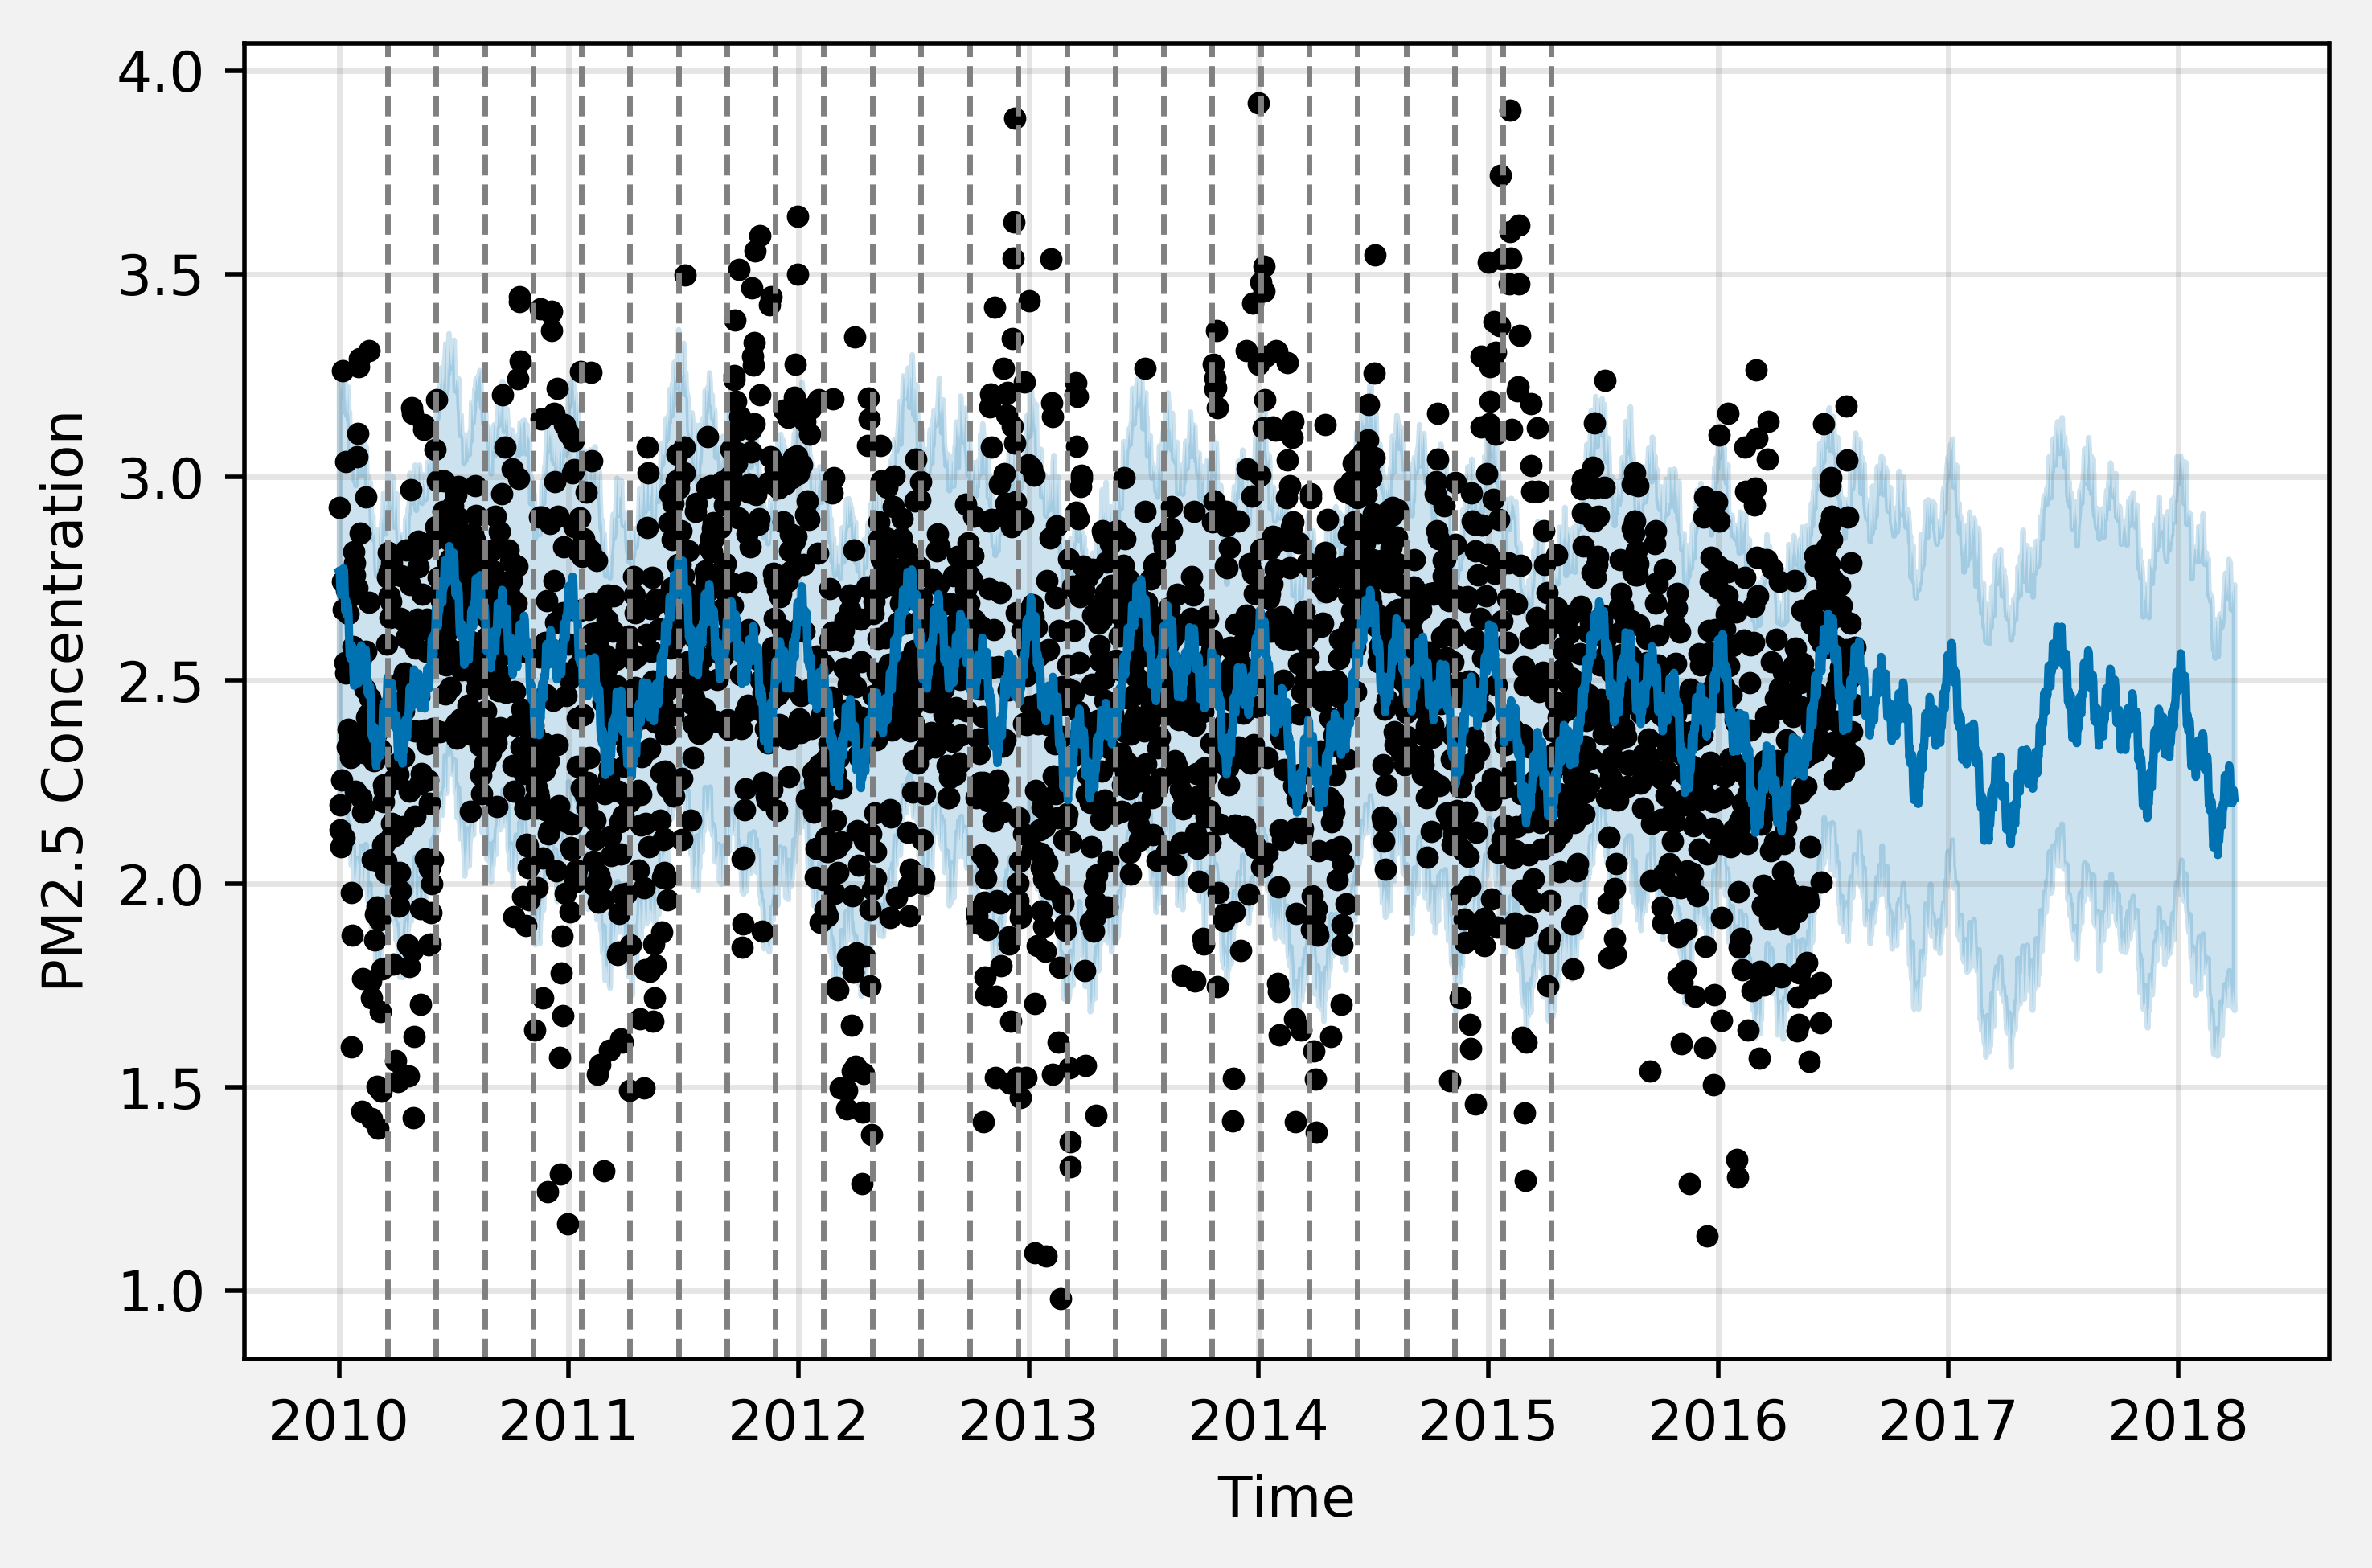

In [1452]:
fig = plt.figure(facecolor='#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor='#F2F2F2'
ax.grid(True,which='Major',c='#701112',ls='-',lw=1, alpha=.2)
q.plot(fore2, ax=ax,xlabel='Time', ylabel='PM2.5 Concentration');
add_changepoints_to_plot(q)

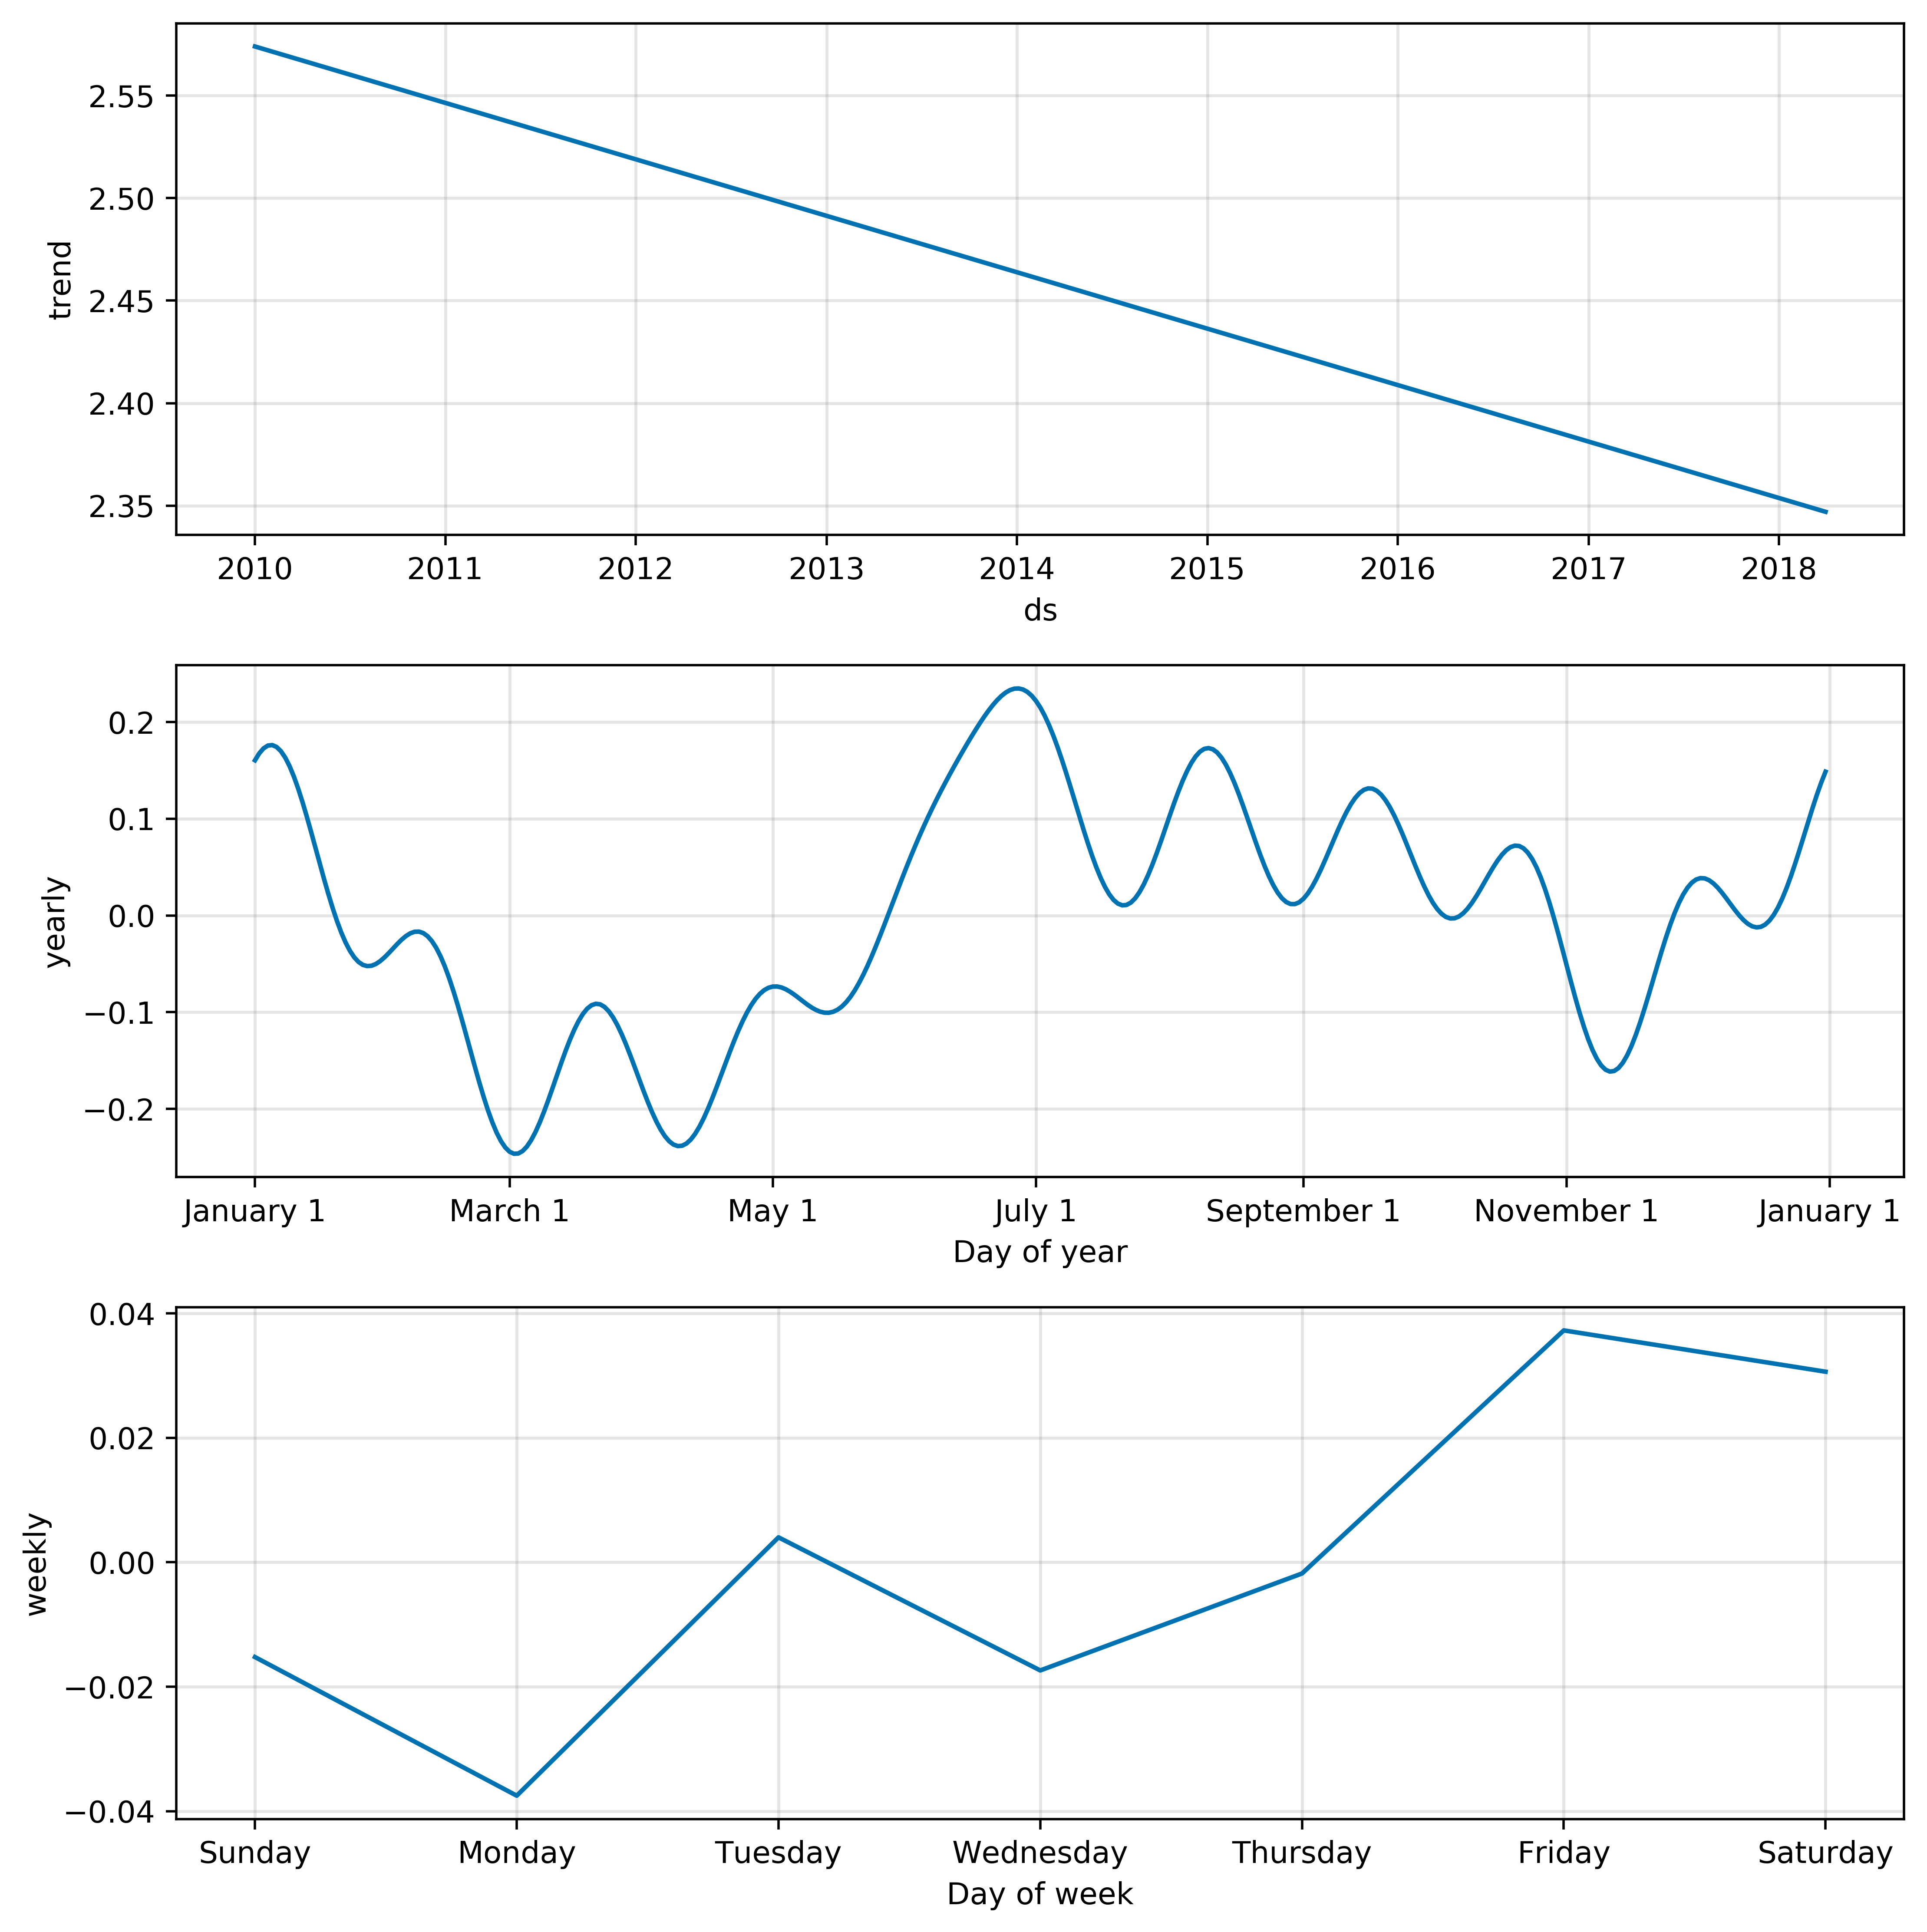

In [1453]:
q.plot_components(fore2);

In [1454]:
_, yhat1 = train_test_split(fore2, test_size = .2, shuffle = False)
dif = len(atest)-len(yhat1)
#yhat1.drop(yhat1.index[:-dif], inplace=True)

In [1455]:
#predictions are 4.78 ppm off from the actual values
yhat1 = yhat1['yhat']
rms1 = math.sqrt(mean_squared_error(atest['y'], yhat1))
rms1/np.mean(atest['y'])

0.158655738925223

### Site Specific
need:
* list: sites
* df: laqi
* function: to create df and push into FB prophet

In [1456]:
df = laqi[laqi['AQS_SITE_ID'] == sites[1]]
laqi['ds'] = pd.to_datetime(laqi.ds)

In [1457]:
df.head()

AQS_SITE_ID  POC  Daily Mean PM2.5 Concentration     UNITS  \
93     60370016    3                             9.2  ug/m3 LC   
94     60370016    3                             4.4  ug/m3 LC   
95     60370016    3                             6.0  ug/m3 LC   
96     60370016    3                            10.0  ug/m3 LC   
97     60370016    3                            10.5  ug/m3 LC   

    DAILY_AQI_VALUE  DAILY_OBS_COUNT  PERCENT_COMPLETE  AQS_PARAMETER_CODE  \
93               38                1             100.0               88502   
94               18                1             100.0               88502   
95               25                1             100.0               88502   
96               42                1             100.0               88502   
97               44                1             100.0               88502   

                        AQS_PARAMETER_DESC  CBSA_CODE  \
93  Acceptable PM2.5 AQI & Speciation Mass      31080   
94  Acceptable PM2.5 AQI & Speciation Mass      31080   
95  Acceptable PM2.5 AQI & Speciation Mass      31080   
96  Acceptable PM2.5 AQI & Speciation Mass      31080   
97  Acceptable PM2.5 AQI & Speciation Mass      31080   

                             CBSA_NAME  STATE_CODE       STATE  COUNTY_CODE  \
93  Los Angeles-Long Beach-Anaheim, CA           6  California           37   
94  Los Angeles-Long Beach-Anaheim, CA           6  California           37   
95  Los Angeles-Long Beach-Anaheim, CA           6  California           37   
96  Los Angeles-Long Beach-Anaheim, CA           6  California           37   
97  Los Angeles-Long Beach-Anaheim, CA           6  California           37   

         COUNTY  SITE_LATITUDE  SITE_LONGITUDE         ds  
93  Los Angeles       34.14435      -117.85036 2010-02-05  
94  Los Angeles       34.14435      -117.85036 2010-02-06  
95  Los Angeles       34.14435      -117.85036 2010-02-07  
96  Los Angeles       34.14435      -117.85036 2010-02-08  
97  Los Angeles       34.14435      -117.85036 2010-02-09

In [1464]:
def fbP(site, scale):
    df = laqi[laqi['AQS_SITE_ID'] == site].copy()
    df['ds'] = pd.to_datetime(df.ds)
    df = df[['ds','Daily Mean PM2.5 Concentration']]
    df.columns = ['ds','y']
    df=df[df['y']>0].copy()
    df['y']= df['y'].apply(lambda x: np.log(x))
    atrain,atest = train_test_split(df, test_size = .2, shuffle = False)
    q = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False,
            changepoint_prior_scale=scale)
    q.fit(atrain)
    per = len(atest)
    fut2 = q.make_future_dataframe(periods=per, freq = 'D')
    fore2 = q.predict(fut2)
    q.plot(fore2, xlabel='Time', ylabel='PM2.5 Concentration');
    #add_changepoints_to_plot(q)
    #q.plot_components(fore2);
    _, yhat1 = train_test_split(fore2, test_size = .2, shuffle = False)
    yhat1 = yhat1['yhat']
    rms1 = math.sqrt(mean_squared_error(atest['y'], yhat1))
    error = rms1/np.mean(atest['y'])
    return (error, scale)

In [1460]:
"""results = []
for i in sites:
    for j in [.1,.01,.001]:
        results.append(fbP(i,j))"""

'results = []\nfor i in sites:\n    for j in [.1,.01,.001]:\n        results.append(fbP(i,j))'

In [1431]:
"""bestparams = []
prev=0
for i in range(3,len(results),3):
    new1 = sorted(results[prev:i], key = lambda x:x[0])
    bestparams.append(new1[0])
    prev = i"""

'bestparams = []\nprev=0\nfor i in range(3,len(results),3):\n    new1 = sorted(results[prev:i], key = lambda x:x[0])\n    bestparams.append(new1[0])\n    prev = i'

In [ ]:
#pulling in climate data
import pickle
with open('bestpriors.pkl', 'rb') as picklefile:
    bestparams = pickle.load(picklefile)

In [ ]:
for x,y in zip(bestparams,sites):
    fbP(y,x[1])

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [1414]:
"""#dumping results in climate data, since the run time to get is long
with open('bestpriors.pkl', 'wb') as picklefile:
    pickle.dump(bestparams,picklefile)"""

### Alaska Particulate Matter Trend

In [1140]:
akpm.head()

ds  Mean PM25  AQI
0 2010-01-02       51.8  141
1 2010-01-05       51.8  141
2 2010-01-08       44.4  123
3 2010-01-11       36.9  104
4 2010-01-20       38.1  107

In [1150]:
color = []
for i in akpm['AQI']:
    if i >300:
        color.append(6)
    elif i>200:
        color.append(5)
    elif i>150:
        color.append(4)
    elif i>100:
        color.append(3)
    elif i>50:
        color.append(2)
    else:
        color.append(1)

In [1208]:
aktrend = akpm[['ds','Mean PM25']]
aktrend.columns = ['ds','y']


In [1209]:
aktrain,aktest = train_test_split(filt, test_size = .15, shuffle = False)

In [1210]:
len(aktest)/len(aktrain)

0.17651203758073988

In [1211]:
#fitting model and forecasting out two years
particle = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            changepoint_prior_scale=.0001,
            daily_seasonality=False)
particle.fit(aktrain)
per = len(aktest)
f1 = particle.make_future_dataframe(periods=per)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



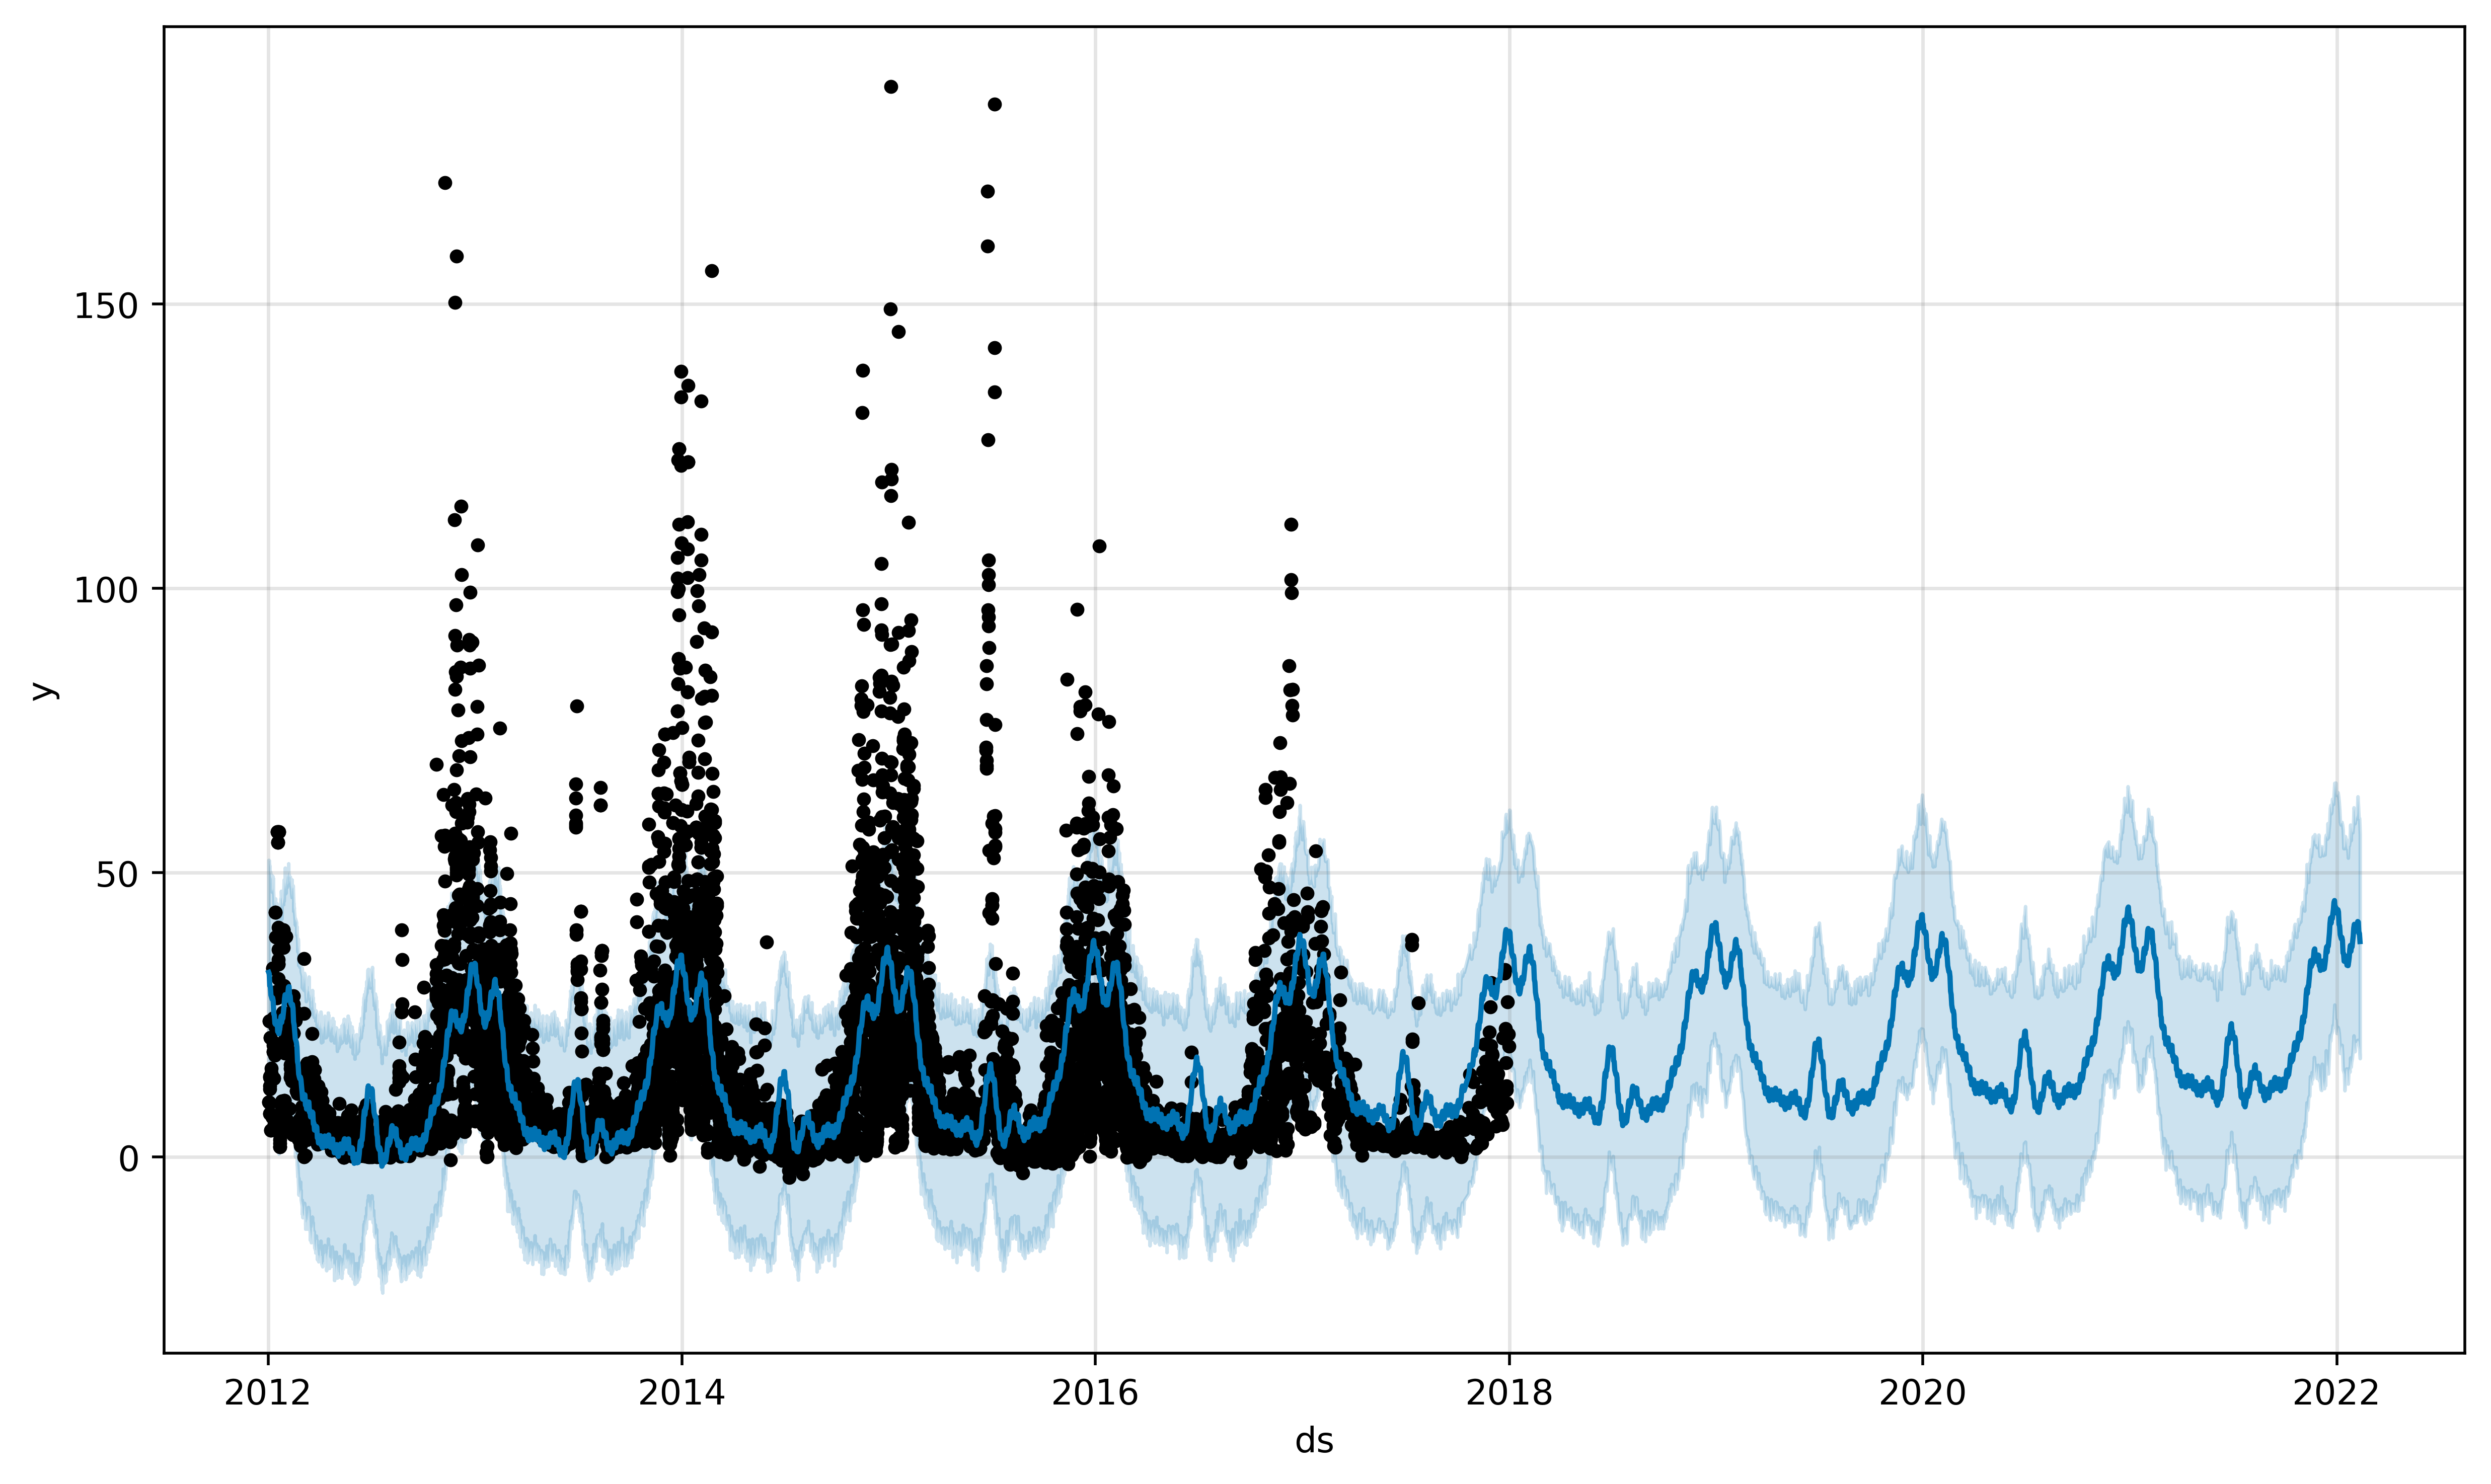

In [1212]:
infut = particle.predict(f1)
mpl.style.use('seaborn-bright')
fig = particle.plot(infut);

In [1213]:
_, yhat1 = train_test_split(infut, test_size = .15, shuffle = False)
dif = len(aktest)-len(yhat1)
yhat1.drop(yhat1.index[:-dif], inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1214]:
len(aktest)-len(yhat1)

0

In [1215]:
#predictions are 4.78 ppm off from the actual values
yhat1 = yhat1['yhat']


In [1216]:
rms1 = math.sqrt(mean_squared_error(aktest['y'], yhat1))
rms1

20.894082718742652

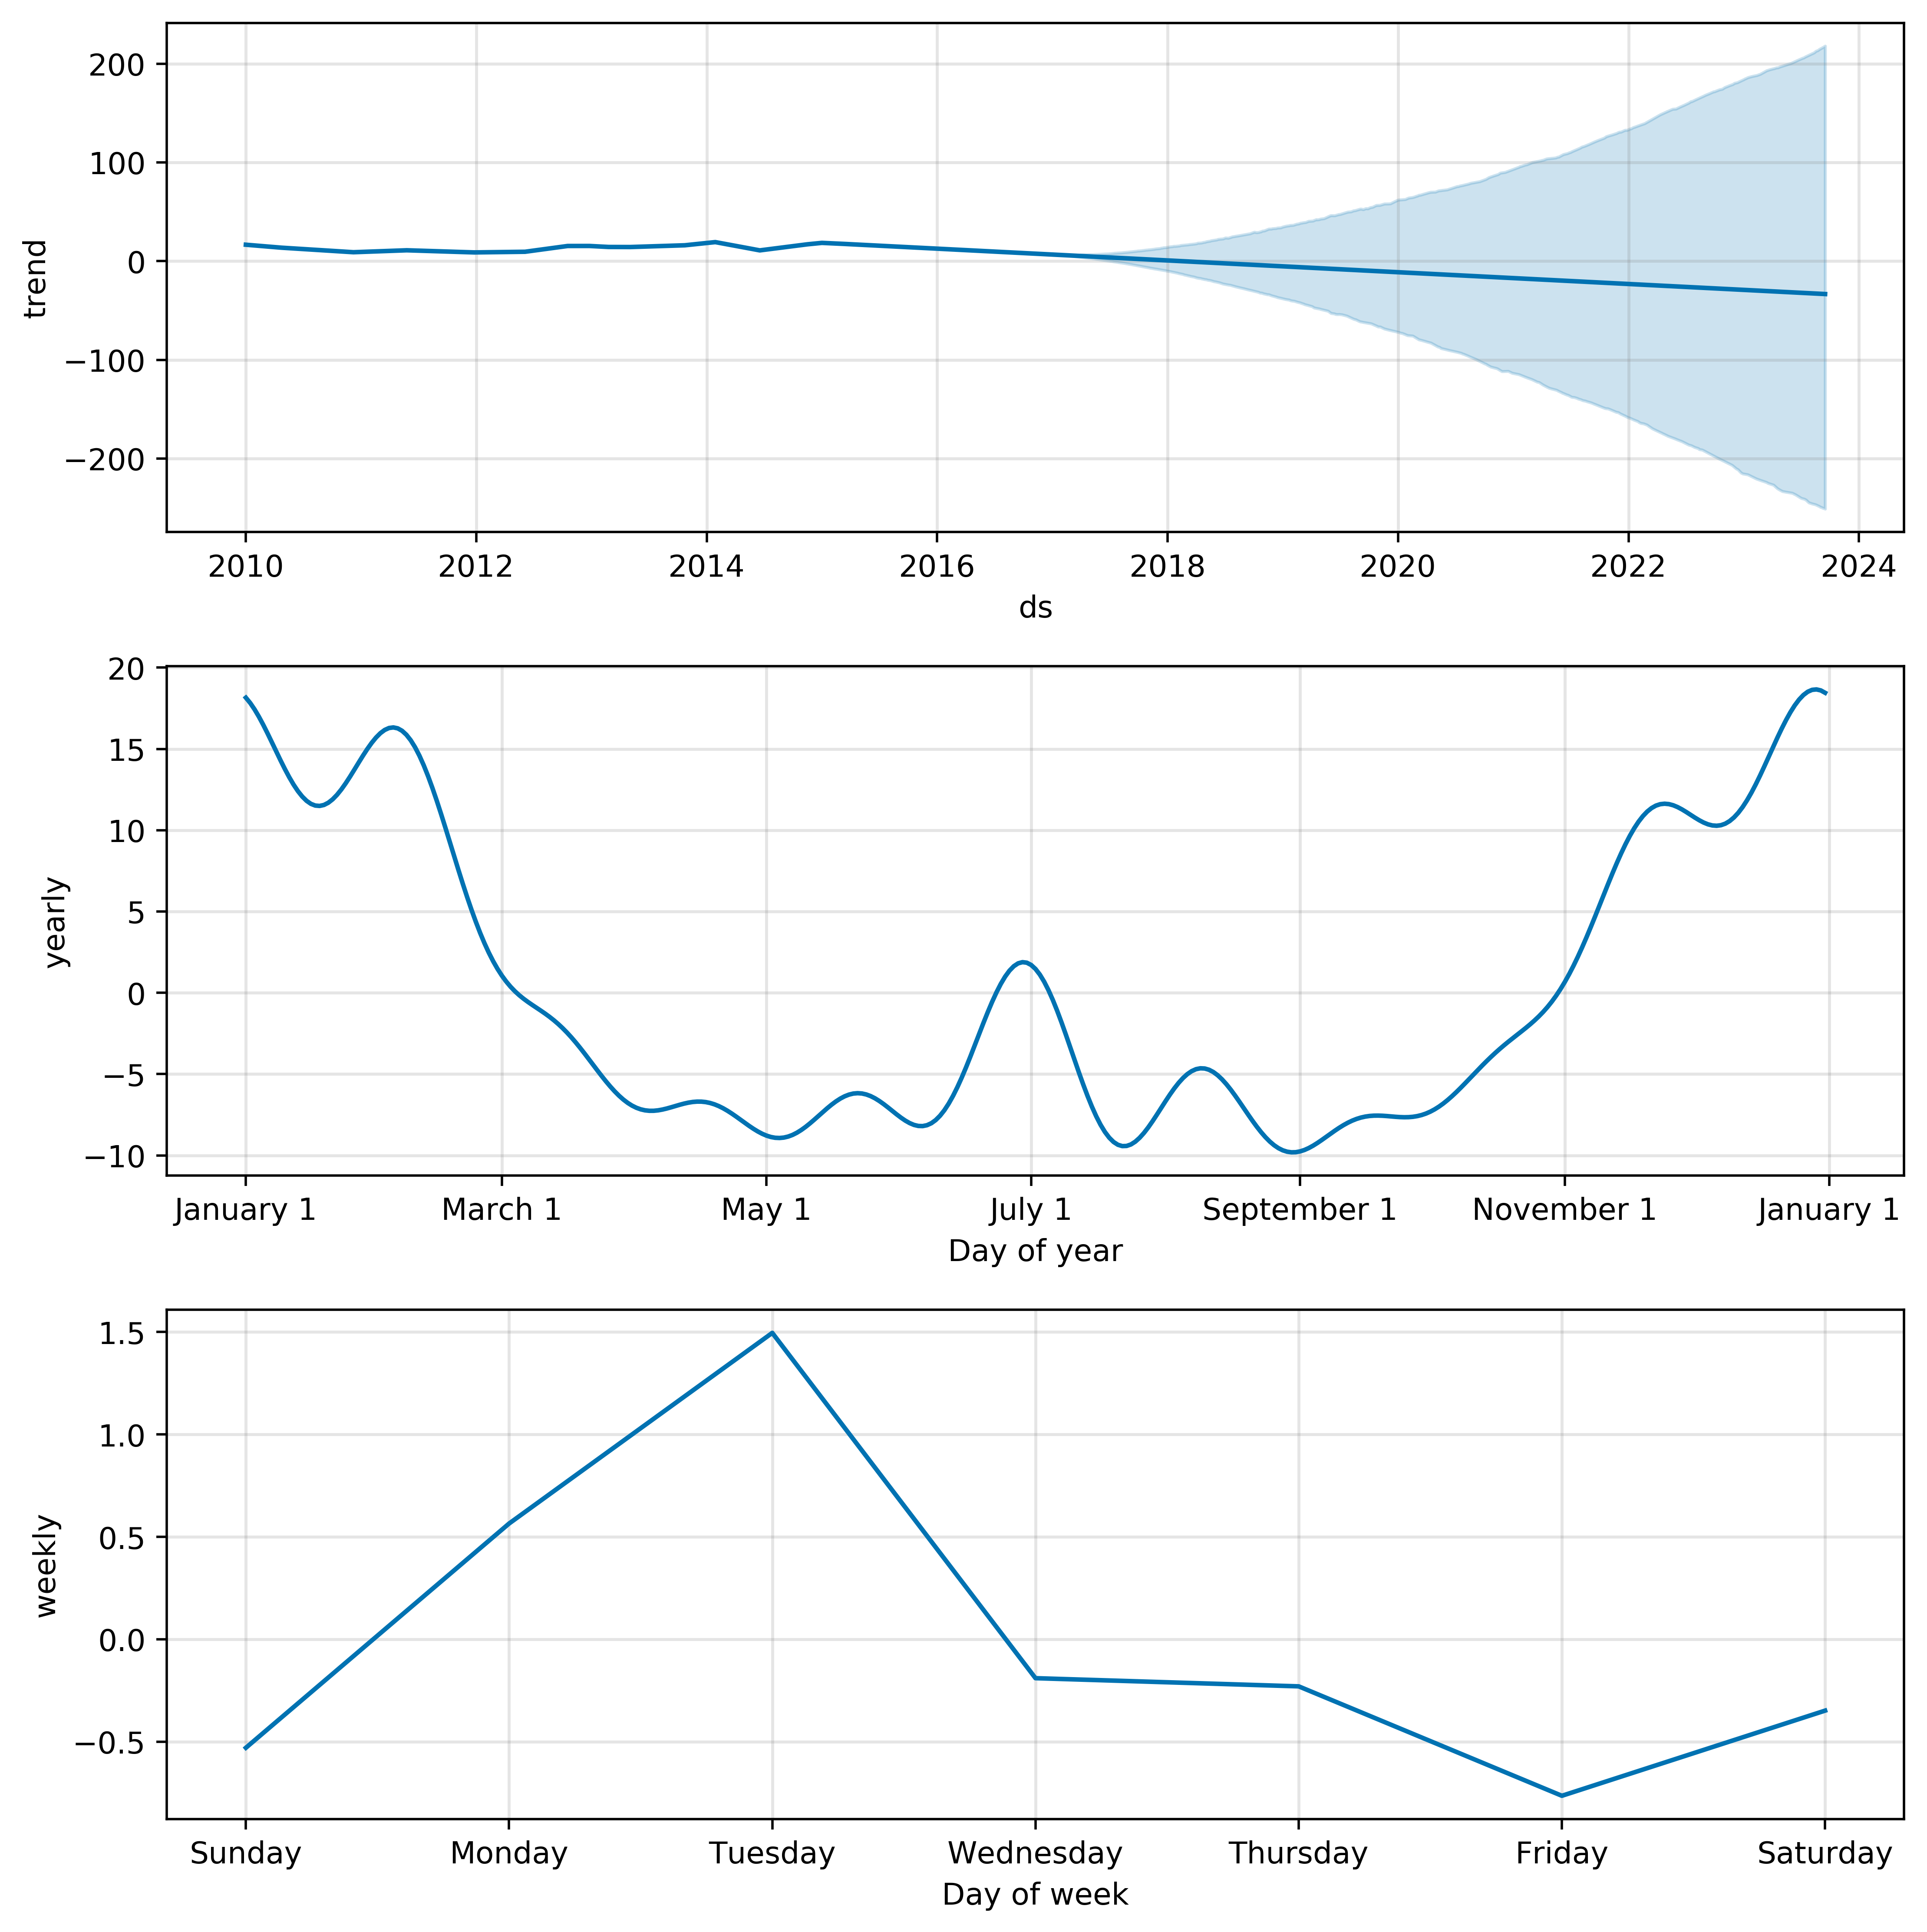

In [1130]:
particle.plot_components(infut);

## Time Series with SARIMAX

Below is the start of the time series predictions.  I will actually start with Prophet since my data is incomplete, then check how it looks with sarmiax after predicting the missing data.

In [1199]:
aktrend.ds = pd.to_datetime(aktrend.ds)
aktrend.set_index('ds', inplace=True)
aktrend.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



y
ds              
2010-01-02  51.8
2010-01-05  51.8
2010-01-08  44.4
2010-01-11  36.9
2010-01-20  38.1

In [1205]:
aktrend.index=pd.to_datetime(aktrend.index)
aktrend = aktrend.resample('D').mean()

In [1206]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(aktrend, model='additive', freq='D')
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values

In [1187]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

In [1192]:
# run DFT on monthly, how many lags back that are used to determine if thereis an underlying trend
dftest(aktrend)

TypeError: descriptor '__sub__' requires a 'datetime.datetime' object but received a 'float'

Test Statistic         -7.323486e+00
p-value                 1.177434e-10
Lags Used               1.000000e+00
Observations Used       3.730000e+02
Critical Value (1%)    -3.448004e+00
Critical Value (5%)    -2.869320e+00
Critical Value (10%)   -2.570915e+00
dtype: float64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()



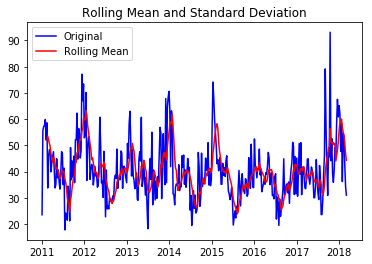

In [211]:
dftest(aqi)

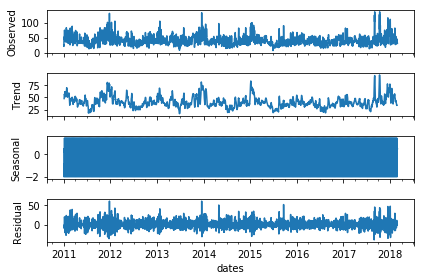

In [35]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(aqidf.AQI)
fig = decomposition.plot()
plt.show()

In [36]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt
def plots(data, lags=None):
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [37]:
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
#order=(p,d,q), seasonal_order=(P,D,Q,m), each variable has a line in above box
sar = sm.tsa.statespace.SARIMAX(co2, order=(0,0,0), seasonal_order=(1,1,1,7), 
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                 CO2 ppm   No. Observations:                 2274
Model:             SARIMAX(1, 1, 1, 7)   Log Likelihood               -7958.364
Date:                 Wed, 13 Jun 2018   AIC                          15922.728
Time:                         22:44:04   BIC                          15939.916
Sample:                     01-06-2011   HQIC                         15928.999
                          - 03-28-2017                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1348      0.026     -5.100      0.000      -0.187      -0.083
ma.S.L7       -0.5169      0.024    -21.253      0.000      -0.565      -0.469
sigma2        67.1678      0.926     72.542      0.000      65.353      68.983
===================================================================================
Ljung-Box (Q):                     2917.06   Jarque-Bera (JB):              6442.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

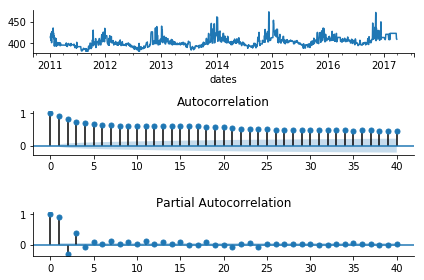

In [38]:
# helper plot for monthly temps
plots(co2, lags=40);

In [40]:
# using itertools to gridsearch solutions
import itertools
import itertools

#set parameter range; UPDATE THESE!
p = q = range(0, 3)
d = range(0, 2)
season = 365

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 365)
SARIMAX: (0, 0, 1) , (0, 0, 2, 365)
SARIMAX: (0, 0, 2) , (0, 1, 0, 365)
SARIMAX: (0, 0, 2) , (0, 1, 1, 365)


In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(co2, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

ARIMA(0, 0, 0),(0, 0, 1, 365) - AIC:28366.24491044973


### optimize our SARIMAX model using itertools: CAREFUL, this can take a while
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(co2, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

In [ ]:

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(aqi, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

In [ ]:
#ARIMA(2, 1, 2),(2, 0, 2, 12) - AIC:12042.917228602186

In [76]:
# build model
co2sar = sm.tsa.statespace.SARIMAX(co2, order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
co2sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            CO2 ppm   No. Observations:                 2274
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6236.622
Date:                            Wed, 13 Jun 2018   AIC                          12483.244
Time:                                    20:19:16   BIC                          12511.890
Sample:                                01-06-2011   HQIC                         12493.694
                                     - 03-28-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2414      0.014    -16.955      0.000      -0.269      -0.213
ma.L1          0.7712      0.010     78.776      0.000       0.752       0.790
ar.S.L12       0.0028      0.000      7.082      0.000       0.002       0.004
ma.S.L12      -0.9842      0.006   -176.513      0.000      -0.995      -0.973
sigma2        14.8467      0.148    100.512      0.000      14.557      15.136
===================================================================================
Ljung-Box (Q):                      291.94   Jarque-Bera (JB):             36592.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.72
Prob(H) (two-sided):                  0.10   Kurtosis:                        22.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# create predictions and confidence intervals
pred = co2sar.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False) # we use as many true values as possible to predict
pred_ci = pred.conf_int()

In [ ]:
# plot predictions
ax = co2['1993':].plot(label='Observed CO2 Levels')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Year')
ax.set_ylabel('CO2')
plt.legend()

plt.show();

In [ ]:
# compute mean square error
fcast = pred.predicted_mean
true = co2['1998-01-01':]

mse = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse, 3)))

In [ ]:
# dynamic forecast
fcast = co2sar.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
fcast_ci = fcast.conf_int()

# caution: this is modeling assumptions on top of assumptions